In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install necessary Repositories

In [6]:
!pip install suod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for suod: filename=suod-0.1.3-py3-none-any.whl size=166733 sha256=8b207a9770c77a59283a7ecbce1bbe778524020579a1efeac15207f35e8e2578
  Stored in directory: /root/.cache/pip/wheels/0e/53/41/1ecb1af1d204b6106273e1320e1cd5dfc91c2f6da1f0855a7d
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42856 sha256=8d36a762665bb013933fa9b75b9f34bce175ea603e501593eed8f7a743763879
  Stored in directory: /root/.cache/pip/wheels/b7/4b/9a/b3fc6e167972ed8eec21e6e9e476457a8b05d8918dc80b649a
Successfully built suod combo


In [2]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.3-py3-none-any.whl size=200466 sha256=0ee38aab55e864e17e4c9e718abb3ccbd9f2fc3058b04cfb1659c3e94206a6df
  Stored in directory: /root/.cache/pip/wheels/2d/60/5b/f74eccd2c9c892a2c298202ca510f10995f9940647fcc2d97f
Successfully built pyod


Import necessary Libraries

In [7]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn import metrics
import scipy.io
import warnings
from scipy.io import savemat

from pyod.models.knn import KNN
from pyod.models.kde import KDE
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
from pyod.models.lunar import LUNAR
from pyod.models.abod import ABOD
from pyod.models.ocsvm import OCSVM
from pyod.models.suod import SUOD
from pyod.models.ecod import ECOD

import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import skew as skew_sp
from sklearn.utils import check_array
from pyod.models.base import BaseDetector
from pyod.utils.stat_models import column_ecdf
import pandas as pd
import seaborn as sns
from sklearn import metrics

In [8]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Convert PyTorch tensor to NumPy array (ensuring float32)
def torch_to_numpy(tensor):
    return tensor.detach().cpu().numpy().astype(np.float32)

Function to evaluate different models

In [36]:
def evaluate_models(algorithms, datasets, device):
    results = {}

    for dataset_name, dataset_path in datasets.items():
        print(f"Evaluating on dataset: {dataset_name}")

        # Load dataset
        df = scipy.io.loadmat(dataset_path)
        numeric = torch.FloatTensor(df['X'])
        labels = df['y'].astype(float).reshape(-1)

        # Convert Torch tensors to NumPy arrays & ensure float32
        numeric_np = torch_to_numpy(numeric)
        labels_np = labels.astype(np.float32)

        # Split dataset for training
        N = 2 * len(labels_np) // 3  # Use 2/3 of data for training

        # Create data loader
        data_loader = DataLoader(numeric, batch_size=1)

        # Initialize results for current dataset
        dataset_results = {
            'dataset': dataset_name,
            'algorithms': {}
        }

        # Evaluate each algorithm
        for alg_name, clf in algorithms.items():
            print(f"Running {alg_name}...")

            # Reset the model to avoid dataset contamination
            clf = algorithms[alg_name].__class__()  # Create a fresh instance


            numeric_train = numeric_np[labels_np == 0].astype(np.float32)
            # Find the minimum number of columns to ensure consistency

            # Convert input to float32 for compatibility


            # Fit the model
            clf.fit(numeric_train)

            # Get predictions and scores
            y_test_pred = []
            y_test_scores = []
            err0 = 0
            err1 = 0
            i = 0

            for data in data_loader:
                data_np = torch_to_numpy(data.to(device))  # Convert batch to NumPy

                # Get predictions
                if hasattr(clf, "predict"):
                    y_pred = clf.predict(data_np.astype(np.float32))
                else:
                    y_scores = clf.decision_function(data_np.astype(np.float32))
                    threshold = np.percentile(y_scores, 98)  # Adjust threshold if needed
                    y_pred = (y_scores > threshold).astype(int)

                y_test_pred.append(y_pred)  # Outlier labels (0 or 1)

                # Get outlier scores
                y_scores = torch.tensor(clf.decision_function(data_np.astype(np.float32))[0]).type(torch.float)
                y_test_scores.append(y_scores)

                # Count false positives and false negatives
                if y_pred == 1 and labels[i] == 0:
                    err0 += 1
                elif y_pred == 0 and labels[i] == 1:
                    err1 += 1

                i += 1

            # Calculate evaluation metrics
            #scores = np.array([s.cpu().numpy() for s in y_test_scores])
            scores = np.array([s.cpu() for s in y_test_scores])
            # Check for NaN or Inf values
            if np.isnan(scores).any() or np.isinf(scores).any():
              print(f"Warning: Found NaN or Inf values in scores for {alg_name} on {dataset_name}")
              scores = np.nan_to_num(scores, nan=0.0, posinf=1.0, neginf=0.0)  # Replace NaN with 0, inf with reasonable values

            auc = metrics.roc_auc_score(labels, scores)
            pr = metrics.average_precision_score(labels, scores)

            # Store results for current algorithm
            dataset_results['algorithms'][alg_name] = {
                'ROC-AUC': auc,
                'AUC-PR': pr,
                'False Positives': err0,
                'False Negatives': err1
            }

            # Print results for current algorithm
            print(f"{alg_name}:")
            print(f"ROC-AUC: {auc:.4f} | AUC-PR: {pr:.4f}")
            print(f"False Positives: {err0} | False Negatives: {err1}")
            print()

        # Store results for current dataset
        results[dataset_name] = dataset_results

    return results

In [37]:
# Define algorithms to evaluate
algorithms = {
    'ECOD': ECOD(),
    'ABOD': ABOD(),
    'OCSVM': OCSVM(),
    'KDE': KDE(),
    'LOF': LOF(),
    'CBLOF': CBLOF(),
    'HBOS': HBOS(),
    'kNN': KNN(),
    'IForest': IForest(),
    'LODA': LODA(),
    'LUNAR': LUNAR()

}

# Define datasets
datasets = {
    #'arrhythmia': '/content/drive/MyDrive/AD_data/arrhythmia.mat',
    'cardio': '/content/drive/MyDrive/AD_data/cardio (1).mat',
    'ionosphere': '/content/drive/MyDrive/AD_data/ionosphere (1).mat',
    'mammography': '/content/drive/MyDrive/AD_data/mammography (1).mat',
    'satimage-2': '/content/drive/MyDrive/AD_data/satimage-2 (1).mat',
    'statlog': '/content/drive/MyDrive/AD_data/statlog (1).mat',
    'pima': '/content/drive/MyDrive/AD_data/pima (1).mat'

}

# Define device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run evaluation
results = evaluate_models(algorithms, datasets, device)


print("Evaluation results:")
print(results)

Evaluating on dataset: cardio
Running ECOD...
ECOD:
ROC-AUC: 0.9713 | AUC-PR: 0.7935
False Positives: 165 | False Negatives: 10

Running ABOD...
ABOD:
ROC-AUC: 0.9541 | AUC-PR: 0.6611
False Positives: 178 | False Negatives: 16

Running OCSVM...
OCSVM:
ROC-AUC: 0.9580 | AUC-PR: 0.6678
False Positives: 166 | False Negatives: 21

Running KDE...
KDE:
ROC-AUC: 0.9856 | AUC-PR: 0.9561
False Positives: 166 | False Negatives: 9

Running LOF...
LOF:
ROC-AUC: 0.9467 | AUC-PR: 0.6509
False Positives: 143 | False Negatives: 31

Running CBLOF...
CBLOF:
ROC-AUC: 0.9396 | AUC-PR: 0.6139
False Positives: 166 | False Negatives: 24

Running HBOS...
HBOS:
ROC-AUC: 0.8751 | AUC-PR: 0.5444
False Positives: 166 | False Negatives: 71

Running kNN...
kNN:
ROC-AUC: 0.9388 | AUC-PR: 0.6908
False Positives: 133 | False Negatives: 45

Running IForest...
IForest:
ROC-AUC: 0.9471 | AUC-PR: 0.6933
False Positives: 166 | False Negatives: 34

Running LODA...
LODA:
ROC-AUC: 0.8784 | AUC-PR: 0.5879
False Positives: 165 

Statistical Inference

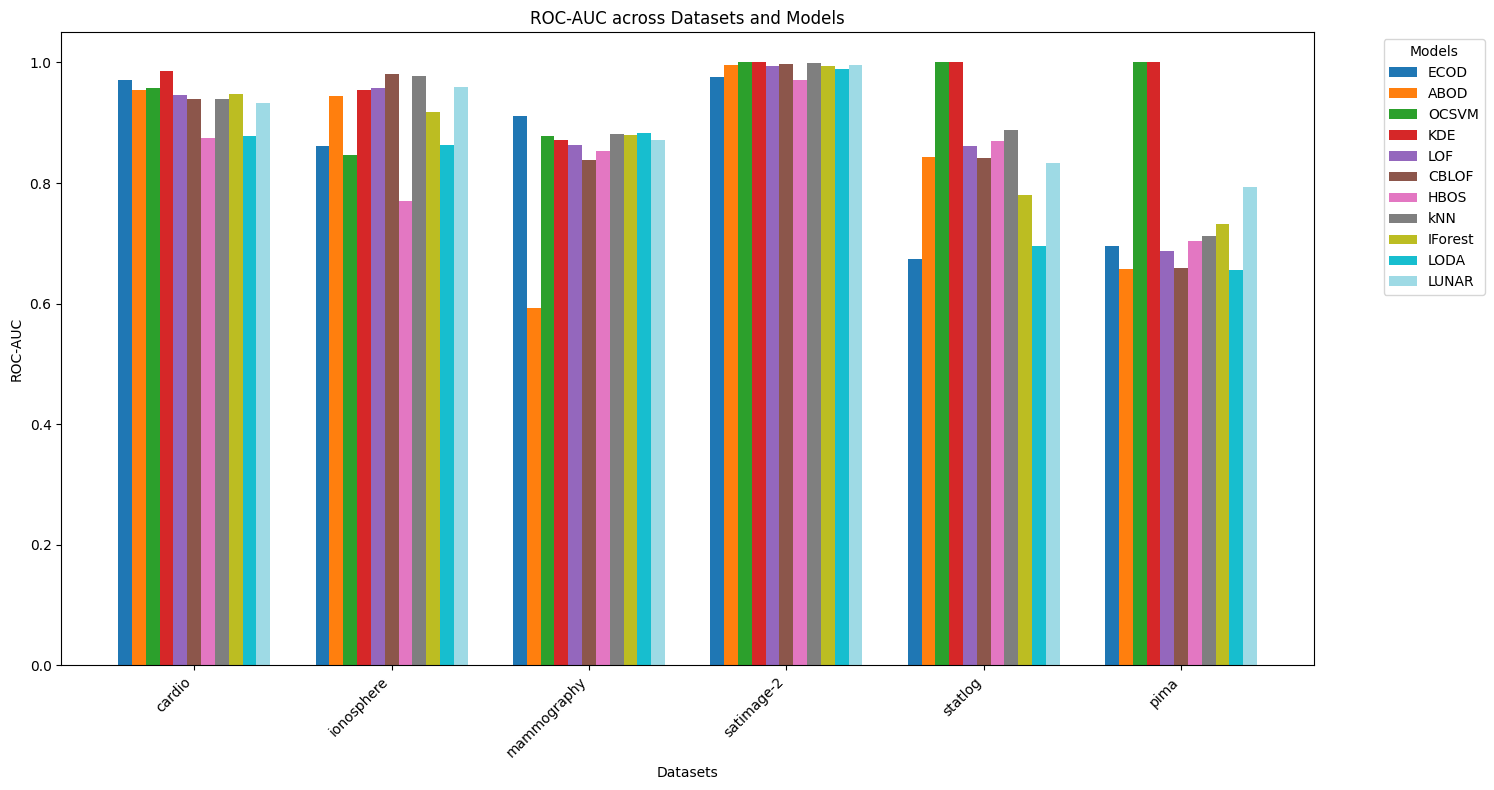

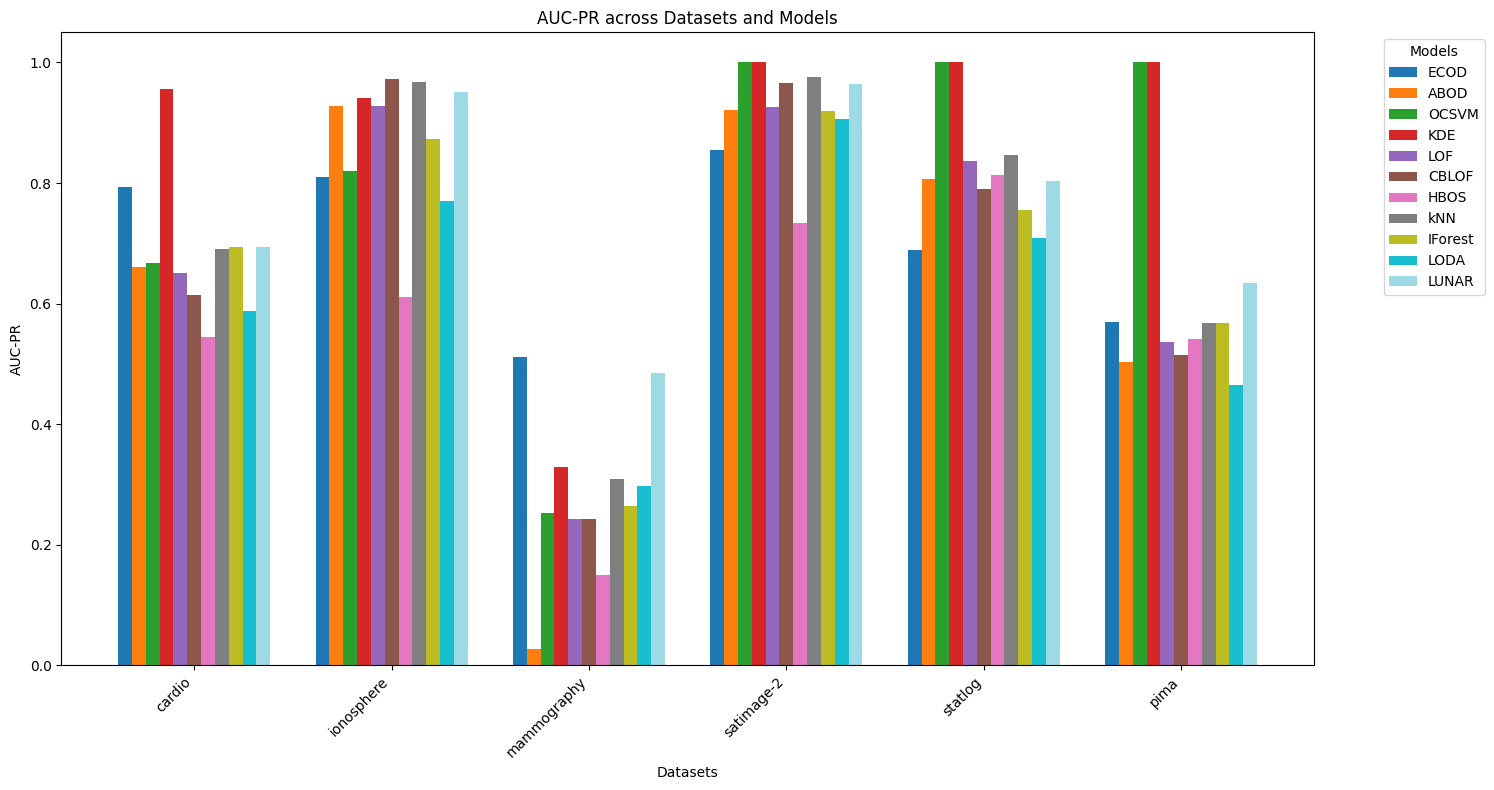

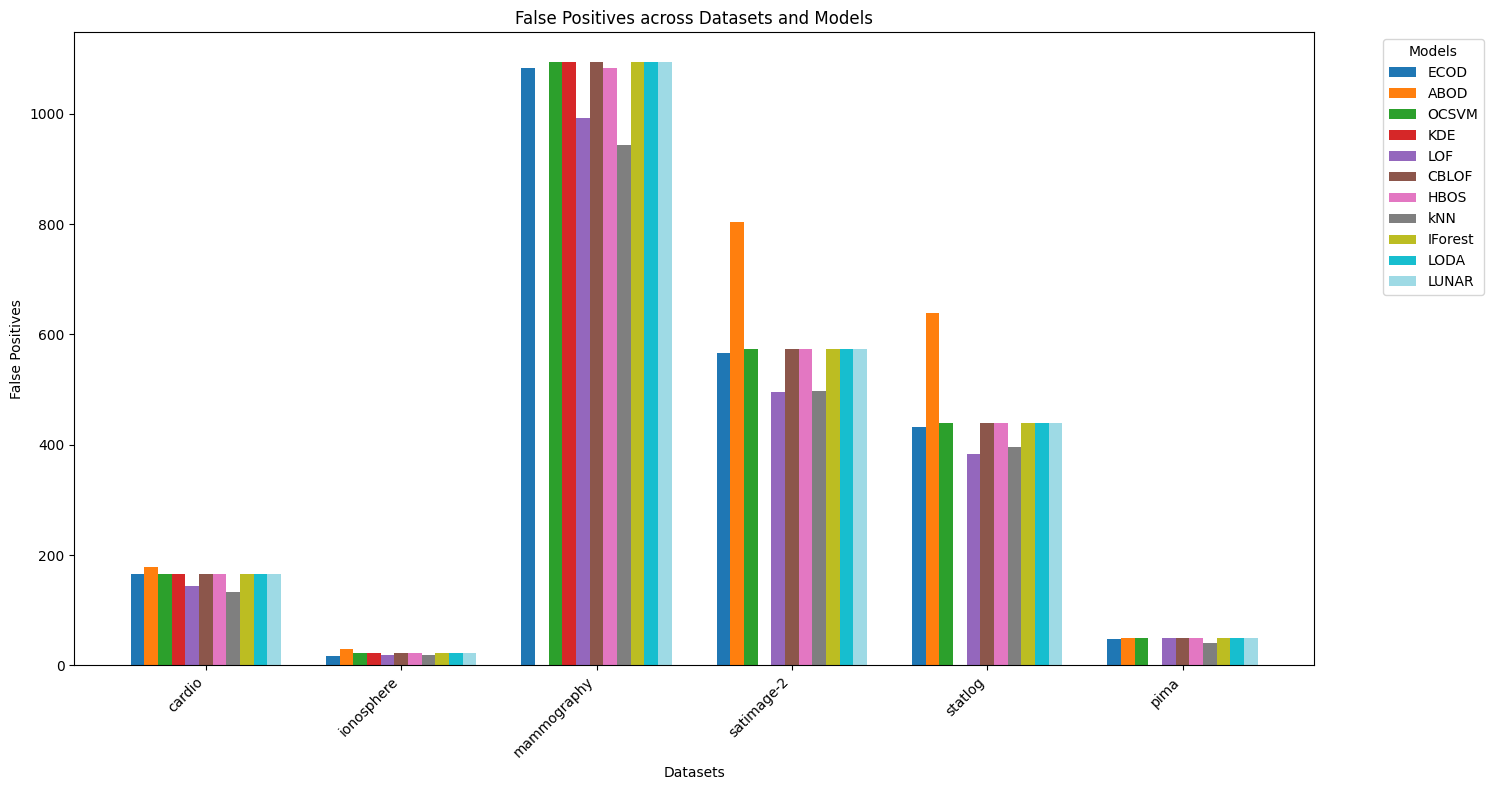

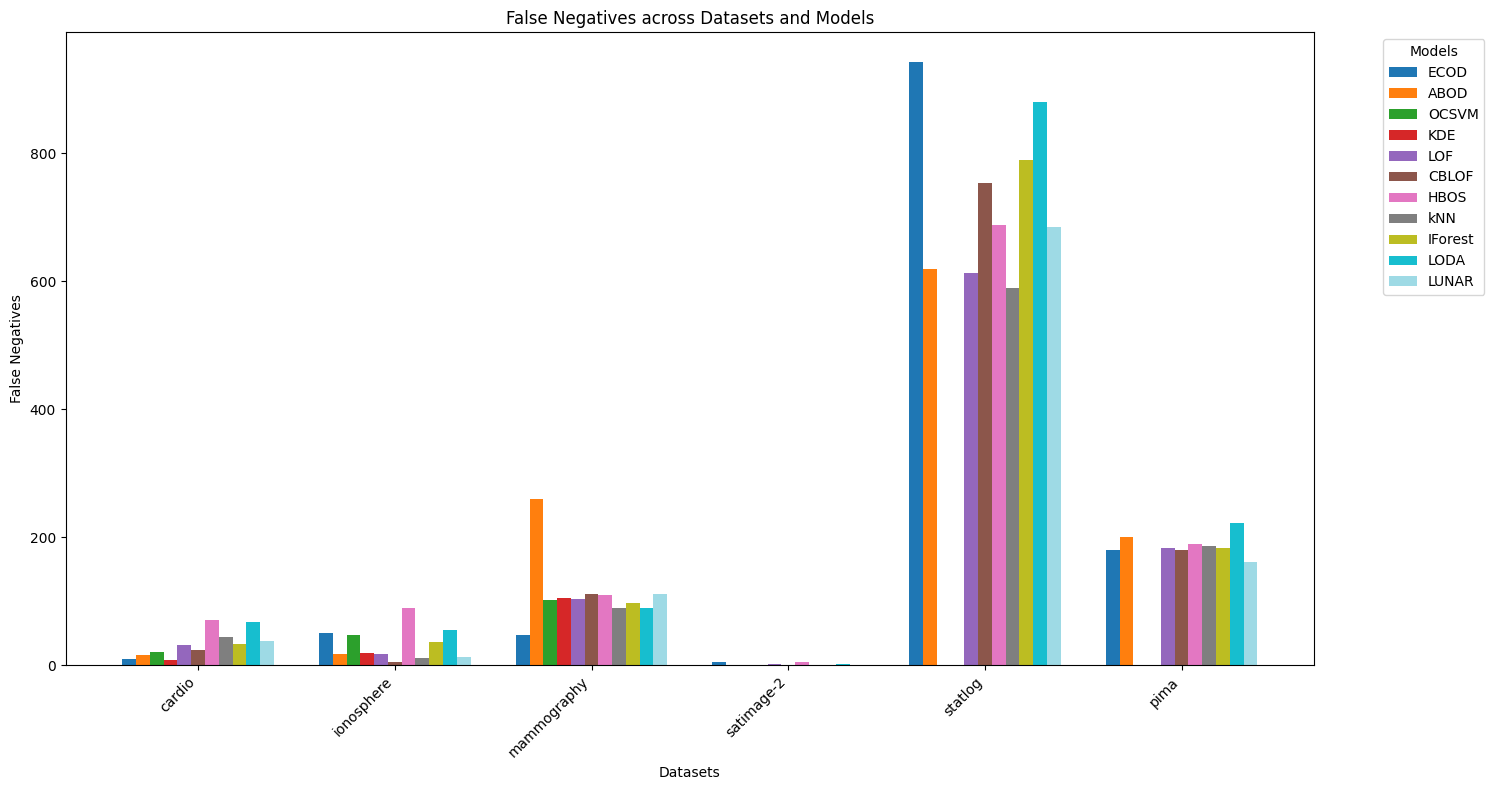

In [40]:


# Raw data organized as nested dictionaries
metrics = {
    'ROC-AUC': {
        'ECOD':    {'cardio':0.9713, 'ionosphere':0.8618, 'mammography':0.9110, 'satimage-2':0.9751, 'statlog':0.6736, 'pima':0.6963},
        'ABOD':    {'cardio':0.9541, 'ionosphere':0.9438, 'mammography':0.5922, 'satimage-2':0.9959, 'statlog':0.8428, 'pima':0.6576},
        'OCSVM':   {'cardio':0.9580, 'ionosphere':0.8469, 'mammography':0.8773, 'satimage-2':1.0000, 'statlog':1.0000, 'pima':1.0000},
        'KDE':     {'cardio':0.9856, 'ionosphere':0.9538, 'mammography':0.8716, 'satimage-2':1.0000, 'statlog':1.0000, 'pima':1.0000},
        'LOF':     {'cardio':0.9467, 'ionosphere':0.9574, 'mammography':0.8638, 'satimage-2':0.9945, 'statlog':0.8611, 'pima':0.6866},
        'CBLOF':   {'cardio':0.9396, 'ionosphere':0.9815, 'mammography':0.8386, 'satimage-2':0.9981, 'statlog':0.8411, 'pima':0.6595},
        'HBOS':    {'cardio':0.8751, 'ionosphere':0.7707, 'mammography':0.8524, 'satimage-2':0.9713, 'statlog':0.8690, 'pima':0.7031},
        'kNN':     {'cardio':0.9388, 'ionosphere':0.9782, 'mammography':0.8809, 'satimage-2':0.9993, 'statlog':0.8876, 'pima':0.7126},
        'IForest': {'cardio':0.9471, 'ionosphere':0.9176, 'mammography':0.8805, 'satimage-2':0.9938, 'statlog':0.7806, 'pima':0.7316},
        'LODA':    {'cardio':0.8784, 'ionosphere':0.8632, 'mammography':0.8829, 'satimage-2':0.9884, 'statlog':0.6958, 'pima':0.6550},
        'LUNAR':   {'cardio':0.9328, 'ionosphere':0.9592, 'mammography':0.8708, 'satimage-2':0.9958, 'statlog':0.8326, 'pima':0.7932}
    },
    'AUC-PR': {
        'ECOD':    {'cardio':0.7935, 'ionosphere':0.8102, 'mammography':0.5108, 'satimage-2':0.8546, 'statlog':0.6883, 'pima':0.5697},
        'ABOD':    {'cardio':0.6611, 'ionosphere':0.9273, 'mammography':0.0264, 'satimage-2':0.9205, 'statlog':0.8061, 'pima':0.5039},
        'OCSVM':   {'cardio':0.6678, 'ionosphere':0.8199, 'mammography':0.2526, 'satimage-2':1.0000, 'statlog':1.0000, 'pima':1.0000},
        'KDE':     {'cardio':0.9561, 'ionosphere':0.9415, 'mammography':0.3282, 'satimage-2':1.0000, 'statlog':1.0000, 'pima':1.0000},
        'LOF':     {'cardio':0.6509, 'ionosphere':0.9283, 'mammography':0.2431, 'satimage-2':0.9255, 'statlog':0.8374, 'pima':0.5365},
        'CBLOF':   {'cardio':0.6139, 'ionosphere':0.9720, 'mammography':0.2421, 'satimage-2':0.9665, 'statlog':0.7902, 'pima':0.5151},
        'HBOS':    {'cardio':0.5444, 'ionosphere':0.6105, 'mammography':0.1496, 'satimage-2':0.7343, 'statlog':0.8139, 'pima':0.5415},
        'kNN':     {'cardio':0.6908, 'ionosphere':0.9679, 'mammography':0.3098, 'satimage-2':0.9762, 'statlog':0.8473, 'pima':0.5678},
        'IForest': {'cardio':0.6933, 'ionosphere':0.8733, 'mammography':0.2645, 'satimage-2':0.9188, 'statlog':0.7556, 'pima':0.5686},
        'LODA':    {'cardio':0.5879, 'ionosphere':0.7707, 'mammography':0.2978, 'satimage-2':0.9063, 'statlog':0.7094, 'pima':0.4650},
        'LUNAR':   {'cardio':0.6934, 'ionosphere':0.9510, 'mammography':0.4852, 'satimage-2':0.9646, 'statlog':0.8027, 'pima':0.6341}
    },
    'False Positives': {
        'ECOD':    {'cardio':165, 'ionosphere':17,  'mammography':1083, 'satimage-2':566, 'statlog':432, 'pima':48},
        'ABOD':    {'cardio':178, 'ionosphere':29,  'mammography':0,    'satimage-2':804, 'statlog':638, 'pima':50},
        'OCSVM':   {'cardio':166, 'ionosphere':23,  'mammography':1093, 'satimage-2':574, 'statlog':440, 'pima':50},
        'KDE':     {'cardio':166, 'ionosphere':23,  'mammography':1093, 'satimage-2':0,   'statlog':0,   'pima':0},
        'LOF':     {'cardio':143, 'ionosphere':19,  'mammography':992,  'satimage-2':495, 'statlog':383, 'pima':49},
        'CBLOF':   {'cardio':166, 'ionosphere':23,  'mammography':1093, 'satimage-2':574, 'statlog':440, 'pima':50},
        'HBOS':    {'cardio':166, 'ionosphere':23,  'mammography':1083, 'satimage-2':574, 'statlog':440, 'pima':50},
        'kNN':     {'cardio':133, 'ionosphere':18,  'mammography':944,  'satimage-2':498, 'statlog':396, 'pima':41},
        'IForest': {'cardio':166, 'ionosphere':23,  'mammography':1093, 'satimage-2':574, 'statlog':440, 'pima':50},
        'LODA':    {'cardio':165, 'ionosphere':23,  'mammography':1093, 'satimage-2':573, 'statlog':439, 'pima':50},
        'LUNAR':   {'cardio':166, 'ionosphere':23,  'mammography':1093, 'satimage-2':574, 'statlog':440, 'pima':50}
    },
    'False Negatives': {
        'ECOD':    {'cardio':10,  'ionosphere':51, 'mammography':48,  'satimage-2':5,   'statlog':942, 'pima':181},
        'ABOD':    {'cardio':16,  'ionosphere':17, 'mammography':260, 'satimage-2':0,   'statlog':620, 'pima':200},
        'OCSVM':   {'cardio':21,  'ionosphere':47, 'mammography':102, 'satimage-2':0,   'statlog':0,   'pima':0},
        'KDE':     {'cardio':9,   'ionosphere':19, 'mammography':106, 'satimage-2':0,   'statlog':0,   'pima':0},
        'LOF':     {'cardio':31,  'ionosphere':17, 'mammography':103, 'satimage-2':2,   'statlog':613, 'pima':184},
        'CBLOF':   {'cardio':24,  'ionosphere':5,  'mammography':111, 'satimage-2':0,   'statlog':753, 'pima':181},
        'HBOS':    {'cardio':71,  'ionosphere':90, 'mammography':110, 'satimage-2':5,   'statlog':688, 'pima':190},
        'kNN':     {'cardio':45,  'ionosphere':12, 'mammography':90,  'satimage-2':0,   'statlog':589, 'pima':186},
        'IForest': {'cardio':34,  'ionosphere':36, 'mammography':97,  'satimage-2':1,   'statlog':790, 'pima':184},
        'LODA':    {'cardio':67,  'ionosphere':55, 'mammography':90,  'satimage-2':2,   'statlog':880, 'pima':222},
        'LUNAR':   {'cardio':38,  'ionosphere':13, 'mammography':112, 'satimage-2':1,   'statlog':685, 'pima':161}
    }
}

# Colors for each model
colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 11))

# Create a plot for each metric
for metric_name, data in metrics.items():
    fig, ax = plt.subplots(figsize=(15, 8))

    datasets = list(data['ECOD'].keys())
    models = list(data.keys())
    x = np.arange(len(datasets))
    width = 0.07  # Width of each bar

    for i, model in enumerate(models):
        values = [data[model][dataset] for dataset in datasets]
        ax.bar(x + i*width, values, width, label=model, color=colors[i])

    ax.set_ylabel(metric_name)
    ax.set_xlabel('Datasets')
    ax.set_title(f'{metric_name} across Datasets and Models')
    ax.set_xticks(x + width * 5)
    ax.set_xticklabels(datasets, rotation=45, ha='right')
    ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

Path of mammography File

In [41]:
path = '/content/drive/MyDrive/AD_data/mammography (1).mat'

Load Data with Anomalies(Labels)

In [42]:
def load_data_with_anomalies(file_path=path):
    # Load the .mat file
    mat_contents = sio.loadmat(file_path)
    # Print the keys to see the structure
    print("Keys in the .mat file:", mat_contents.keys())
    # Extract data and labels
    data = mat_contents['X']
    labels = mat_contents['y']
    return data, labels

In [43]:
def plot_data_with_anomalies(data, labels):
    # Reduce dimensionality to 2D for visualization
    if data.shape[1] > 2:
        print(f"Reducing dimensions from {data.shape[1]} to 2...")
        # Try t-SNE first, fall back to PCA if it fails
        try:
            tsne = TSNE(n_components=2, random_state=42)
            data_2d = tsne.fit_transform(data)
            method = "t-SNE"
        except:
            pca = PCA(n_components=2)
            data_2d = pca.fit_transform(data)
            method = "PCA"
        print(f"Reduced to 2D using {method}")
    else:
        data_2d = data

    # Convert labels to binary (0 for normal, 1 for anomaly)
    binary_labels = labels.astype(int)
    # Reshape labels if needed
    if binary_labels.ndim > 1:
        binary_labels = binary_labels.ravel()

    # Separate normal points and anomalies
    normal_mask = binary_labels == 0
    anomaly_mask = binary_labels == 1

    normal_points = data_2d[normal_mask]
    anomaly_points = data_2d[anomaly_mask]

    print(f"Normal points: {normal_points.shape[0]}")
    print(f"Anomaly points: {anomaly_points.shape[0]}")

    # Create figure with white background and no axes
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_facecolor('white')

    # Plot normal points in blue
    plt.scatter(normal_points[:, 0], normal_points[:, 1],
                c='blue', marker='.', s=50, label='Normal')

    # Plot anomalies in red
    plt.scatter(anomaly_points[:, 0], anomaly_points[:, 1],
                c='red', marker='.', s=50, label='Outlier')

    # Create a simple legend
    plt.legend(loc='lower right', markerscale=2)

    # Set title and format
    plt.axis('equal')

    # Remove axes for cleaner look
    plt.axis('off')

    # Add a border around the plot
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.tight_layout()
    plt.show()

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Reducing dimensions from 6 to 2...
Reduced to 2D using t-SNE
Normal points: 10923
Anomaly points: 260


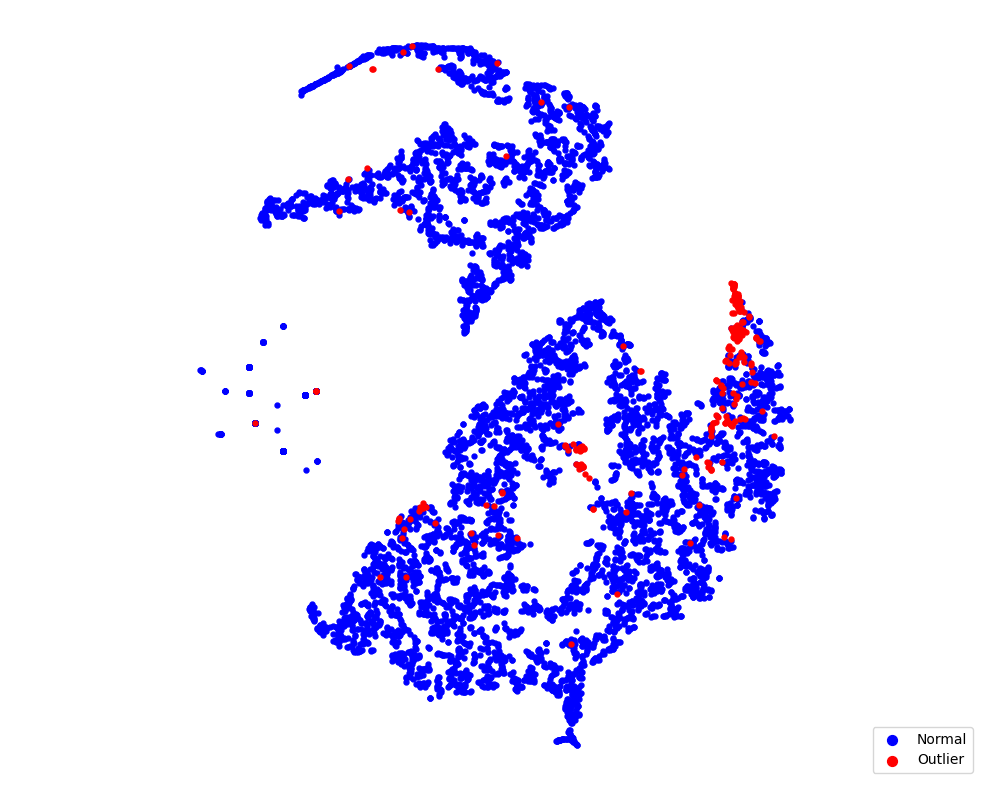

In [44]:
file_path = path  # Replace with the actual file path
data, labels = load_data_with_anomalies(file_path)
if data is not None and labels is not None:
    plot_data_with_anomalies(data, labels)

Load Data without Labels


In [45]:

def load_data(file_path):
    # Load the .mat file
    mat_contents = sio.loadmat(file_path)
    # Print the keys to see the structure
    print("Keys in the .mat file:", mat_contents.keys())
    # Extract data
    data = mat_contents['X']
    return data  # Only return data, not labels

Plot Different Anomaly Detection Models


In [64]:
def plot_multiple_anomaly_detections(algorithms, data, contamination=0.1):
    # Define all anomaly detection algorithms

    # Reduce dimensionality to 2D for visualization
    if data.shape[1] > 2:
        print(f"Reducing dimensions from {data.shape[1]} to 2...")
        try:
            tsne = TSNE(n_components=2, random_state=42)
            data_2d = tsne.fit_transform(data)
            method = "t-SNE"
        except:
            pca = PCA(n_components=2)
            data_2d = pca.fit_transform(data)
            method = "PCA"
        print(f"Reduced to 2D using {method}")
    else:
        data_2d = data

    # Calculate grid size based on number of algorithms
    n_algorithms = len(algorithms)
    n_cols = 3  # Fixed number of columns
    n_rows = (n_algorithms + n_cols - 1) // n_cols  # Ceiling division

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = np.array([axes])  # Ensure axes is always 2D
    axes = axes.flatten()

    # Apply each algorithm and plot results
    for i, (name, model) in enumerate(algorithms.items()):
        print(f"Applying {name}...")
        # Fit the model
        model.fit(data)

        # Get the outlier predictions
        y_pred = model.predict(data)

        # Separate normal points and anomalies
        normal_mask = y_pred == 0
        anomaly_mask = y_pred == 1

        normal_points = data_2d[normal_mask]
        anomaly_points = data_2d[anomaly_mask]

        # Access the current subplot
        ax = axes[i]

        # Plot normal points in blue
        ax.scatter(normal_points[:, 0], normal_points[:, 1],
                   c='blue', marker='.', s=10, label='Normal')

        # Plot anomalies in red
        ax.scatter(anomaly_points[:, 0], anomaly_points[:, 1],
                   c='red', marker='.', s=10, label='Outlier')

        # Set title and format
        ax.set_title(f'{name} ({np.sum(anomaly_mask)} outliers)')
        ax.axis('off')

        # Add a border
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')

        # Add legend
        ax.legend(loc='lower right', fontsize='small')

        print(f"{name}: {np.sum(anomaly_mask)} anomalies detected.")

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Reducing dimensions from 6 to 2...
Reduced to 2D using t-SNE
Applying ECOD...
ECOD: 1119 anomalies detected.
Applying KDE...
KDE: 1119 anomalies detected.
Applying LOF...
LOF: 1004 anomalies detected.
Applying CBLOF...
CBLOF: 1119 anomalies detected.
Applying HBOS...
HBOS: 1089 anomalies detected.
Applying kNN...
kNN: 962 anomalies detected.
Applying IForest...
IForest: 1119 anomalies detected.
Applying LODA...
LODA: 1119 anomalies detected.
Applying ABOD...
ABOD: 0 anomalies detected.
Applying OCSVM...
OCSVM: 1119 anomalies detected.
Applying LUNAR...
LUNAR: 1119 anomalies detected.


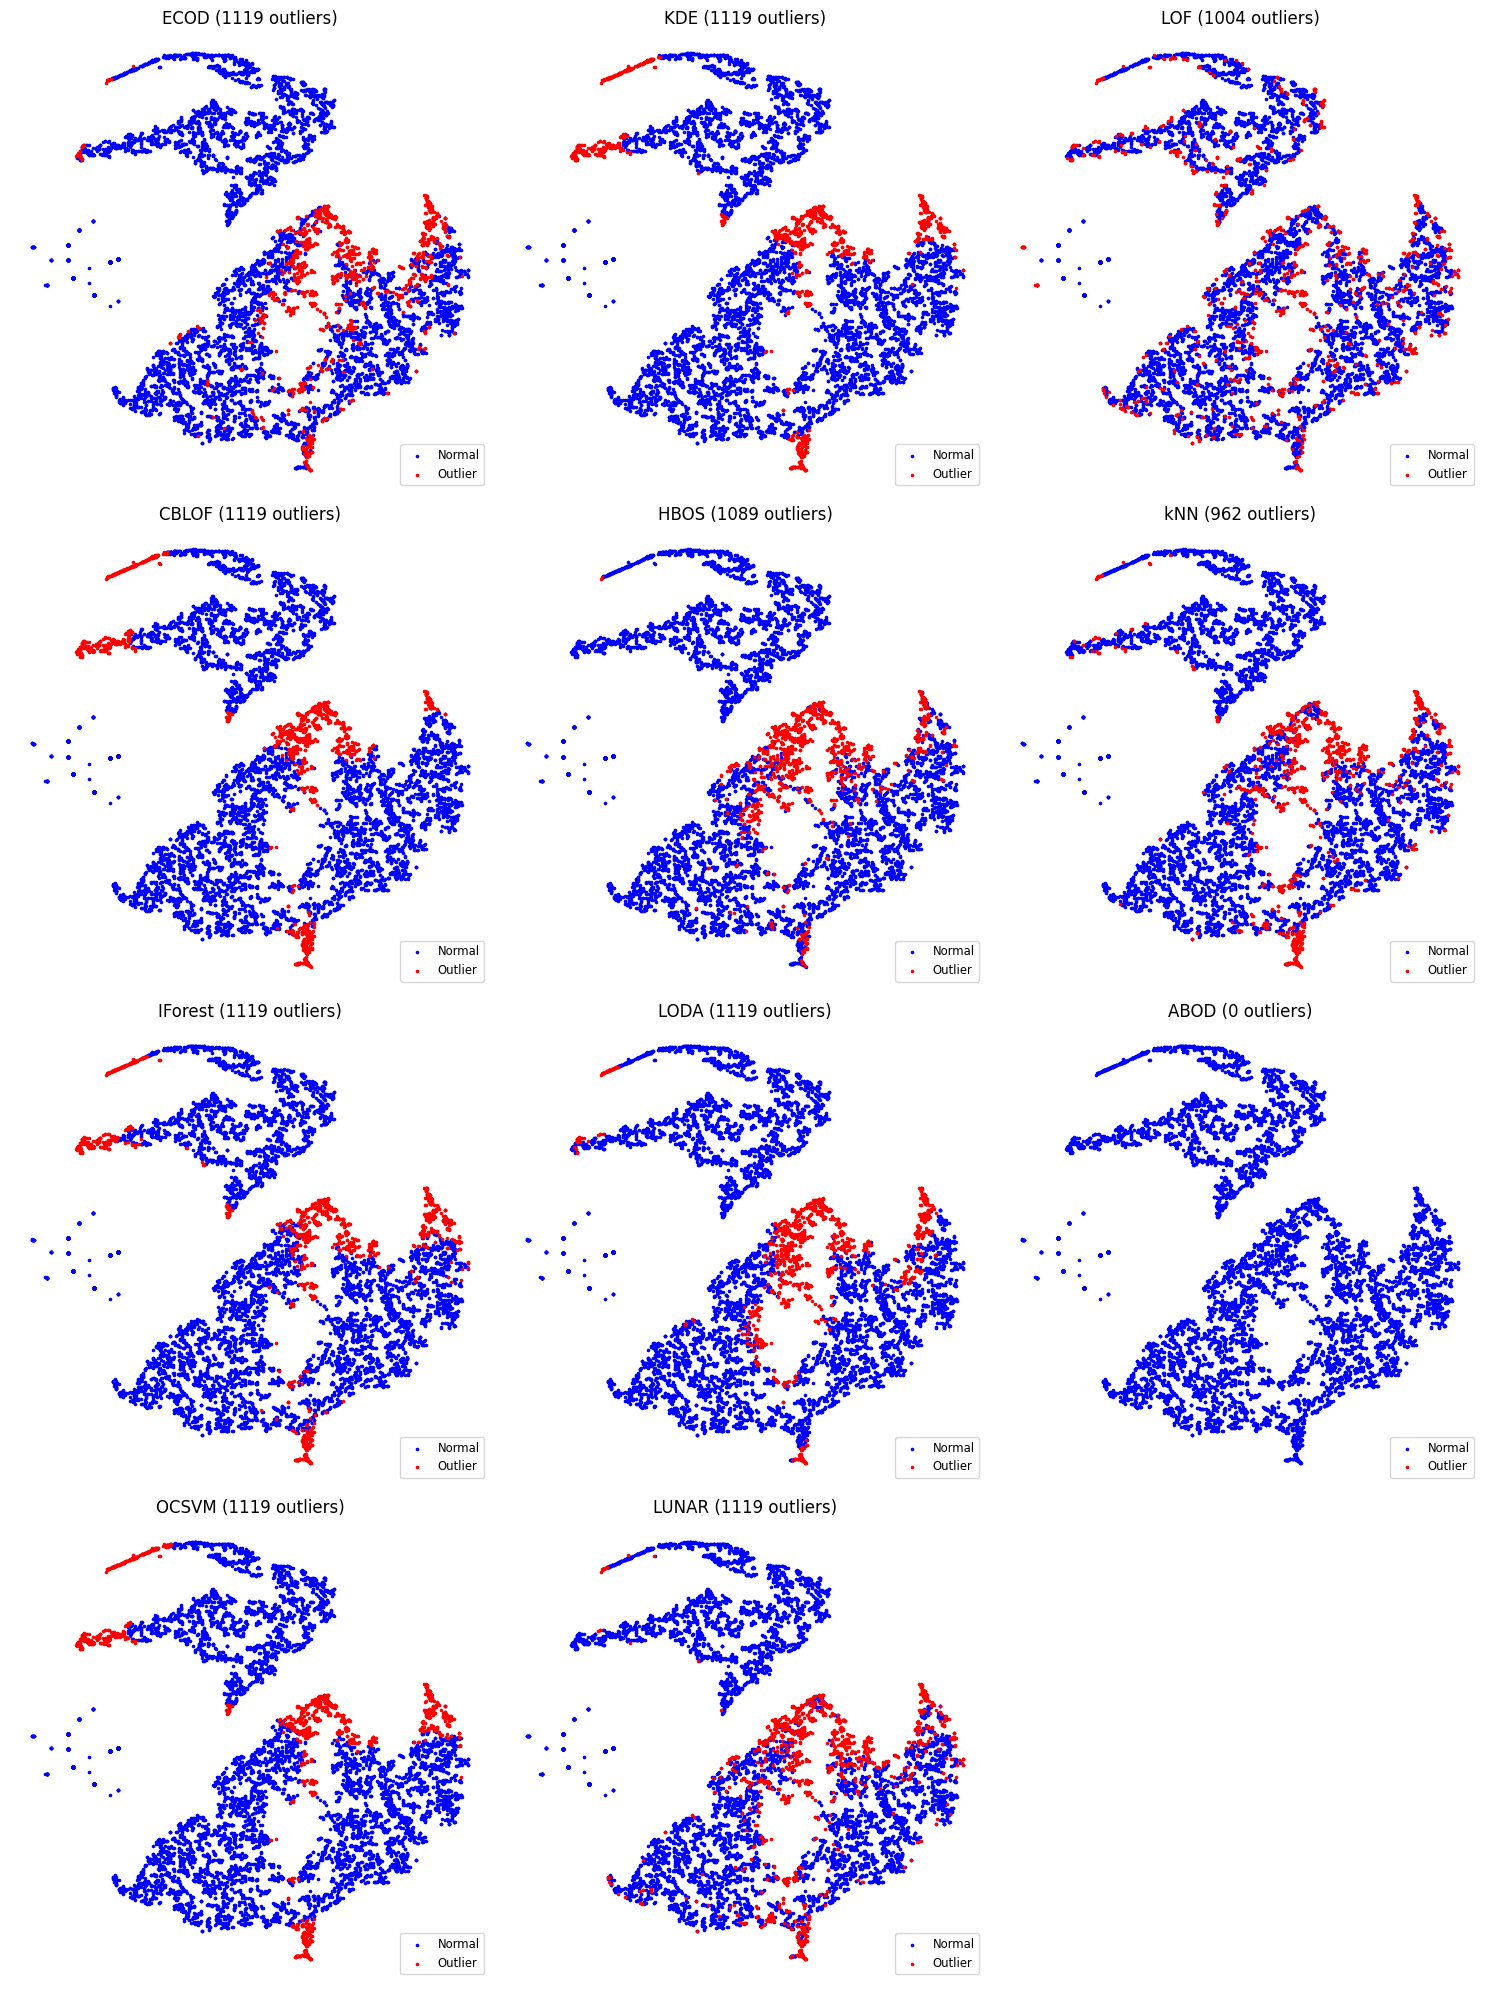

In [48]:
# Main execution
contamination = 0.1
algorithms = {
        "ECOD": ECOD(contamination=contamination),
        "KDE": KDE(contamination=contamination),
        "LOF": LOF(contamination=contamination),
        "CBLOF": CBLOF(contamination=contamination, n_clusters=8),
        "HBOS": HBOS(contamination=contamination),
        "kNN": KNN(contamination=contamination),
        "IForest": IForest(contamination=contamination, random_state=42),
        "LODA": LODA(contamination=contamination),
        "ABOD": ABOD(contamination=contamination),
        "OCSVM": OCSVM(contamination=contamination),
        "LUNAR": LUNAR(contamination=contamination)

    }
file_path = path  # Replace with your actual file path
data = load_data(file_path)
if data is not None:
    # Apply all algorithms with 10% contamination
    plot_multiple_anomaly_detections(algorithms, data)


Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


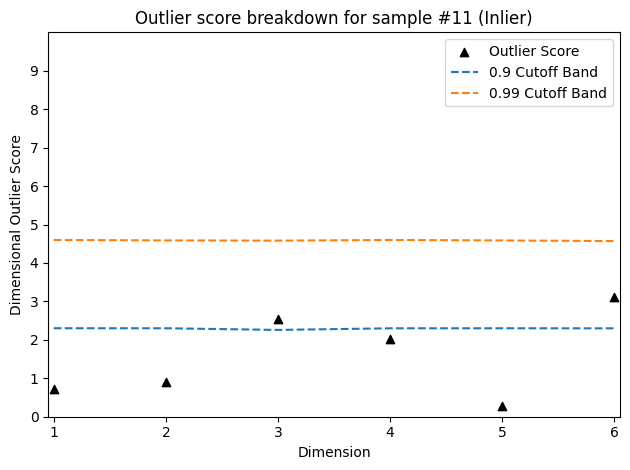

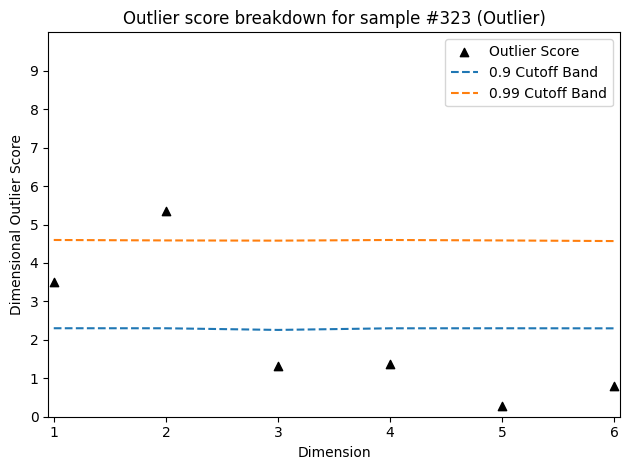

In [49]:
data = load_data(path)
ecod = ECOD(contamination=0.1)
ecod.fit(data)
ypred = ecod.predict(data)
ecod.explain_outlier(ind = 10)    # Inlier
ecod.explain_outlier(ind = 322)   # Outlier

ECOD_L Class

In [50]:
"""ECOD_L: Left-tail only variant of ECOD algorithm"""


class ECOD_L(BaseDetector):

    def __init__(self, contamination=0.1, n_jobs=1):
        super(ECOD_L, self).__init__(contamination=contamination)
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        X = check_array(X)
        self._set_n_classes(y)
        self.decision_scores_ = self.decision_function(X)
        self.X_train = X
        self._process_decision_scores()
        return self

    def decision_function(self, X):
        X = check_array(X)
        if hasattr(self, 'X_train'):
            original_size = X.shape[0]
            X = np.concatenate((self.X_train, X), axis=0)

        # Calculate left-tail probabilities
        self.U_l = -1 * np.log(column_ecdf(X))

        # Use only left-tail (ECOD-L variant)
        self.O = self.U_l

        if hasattr(self, 'X_train'):
            decision_scores_ = self.O.sum(axis=1)[-original_size:]
        else:
            decision_scores_ = self.O.sum(axis=1)
        return decision_scores_.ravel()




ECOD_R Class

In [51]:
"""ECOD_R: Right-tail only variant of ECOD algorithm"""

class ECOD_R(BaseDetector):

    def __init__(self, contamination=0.1, n_jobs=1):
        super(ECOD_R, self).__init__(contamination=contamination)
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        X = check_array(X)
        self._set_n_classes(y)
        self.decision_scores_ = self.decision_function(X)
        self.X_train = X
        self._process_decision_scores()
        return self

    def decision_function(self, X):
        X = check_array(X)
        if hasattr(self, 'X_train'):
            original_size = X.shape[0]
            X = np.concatenate((self.X_train, X), axis=0)

        # Calculate right-tail probabilities
        self.U_r = -1 * np.log(column_ecdf(-X))

        # Use only right-tail (ECOD-R variant)
        self.O = self.U_r

        if hasattr(self, 'X_train'):
            decision_scores_ = self.O.sum(axis=1)[-original_size:]
        else:
            decision_scores_ = self.O.sum(axis=1)
        return decision_scores_.ravel()


ECOD_B Class

In [57]:
"""ECOD_B: Average of ECOD_R and ECOD_L"""

class ECOD_B(BaseDetector):

    def __init__(self, contamination=0.1, n_jobs=1):
        super(ECOD_B, self).__init__(contamination=contamination)
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        X = check_array(X)
        self._set_n_classes(y)
        self.decision_scores_ = self.decision_function(X)
        self.X_train = X
        self._process_decision_scores()
        return self

    def decision_function(self, X):
        X = check_array(X)
        if hasattr(self, 'X_train'):
            original_size = X.shape[0]
            X = np.concatenate((self.X_train, X), axis=0)

        # Calculate right-tail probabilities
        self.U_b = -0.5 * np.log(column_ecdf(-X)) + -0.5 * np.log(column_ecdf(X))

        # Use only right-tail (ECOD-R variant)
        self.O = self.U_b

        if hasattr(self, 'X_train'):
            decision_scores_ = self.O.sum(axis=1)[-original_size:]
        else:
            decision_scores_ = self.O.sum(axis=1)
        return decision_scores_.ravel()

Compare ECOD, ECOD_L, ECOD_R

In [77]:

# Define algorithms to evaluate
algorithms = {
    'ECOD': ECOD(),
    'ECOD_L': ECOD_L(),
    'ECOD_R': ECOD_R(),
    'ECOD_B': ECOD_B()
}

# Define datasets
datasets = {
    'cardio': '/content/drive/MyDrive/AD_data/cardio (1).mat',
    'ionosphere': '/content/drive/MyDrive/AD_data/ionosphere (1).mat',
    'mammography': '/content/drive/MyDrive/AD_data/mammography (1).mat',
    'satimage-2': '/content/drive/MyDrive/AD_data/satimage-2 (1).mat',
    'statlog': '/content/drive/MyDrive/AD_data/statlog (1).mat',
    'pima': '/content/drive/MyDrive/AD_data/pima (1).mat'

}

# Define device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run evaluation
results = evaluate_models(algorithms, datasets, device)


print("Evaluation results:")
print(results)

Evaluating on dataset: cardio
Running ECOD...
ECOD:
ROC-AUC: 0.9713 | AUC-PR: 0.7935
False Positives: 165 | False Negatives: 10

Running ECOD_L...
ECOD_L:
ROC-AUC: 0.9249 | AUC-PR: 0.6260
False Positives: 162 | False Negatives: 43

Running ECOD_R...
ECOD_R:
ROC-AUC: 0.9728 | AUC-PR: 0.8042
False Positives: 161 | False Negatives: 7

Running ECOD_B...
ECOD_B:
ROC-AUC: 0.9728 | AUC-PR: 0.8042
False Positives: 161 | False Negatives: 7

Evaluating on dataset: ionosphere
Running ECOD...
ECOD:
ROC-AUC: 0.8618 | AUC-PR: 0.8102
False Positives: 17 | False Negatives: 51

Running ECOD_L...
ECOD_L:
ROC-AUC: 0.8592 | AUC-PR: 0.7946
False Positives: 18 | False Negatives: 52

Running ECOD_R...
ECOD_R:
ROC-AUC: 0.8799 | AUC-PR: 0.8297
False Positives: 16 | False Negatives: 50

Running ECOD_B...
ECOD_B:
ROC-AUC: 0.8799 | AUC-PR: 0.8297
False Positives: 16 | False Negatives: 50

Evaluating on dataset: mammography
Running ECOD...
ECOD:
ROC-AUC: 0.9110 | AUC-PR: 0.5108
False Positives: 1083 | False Negati

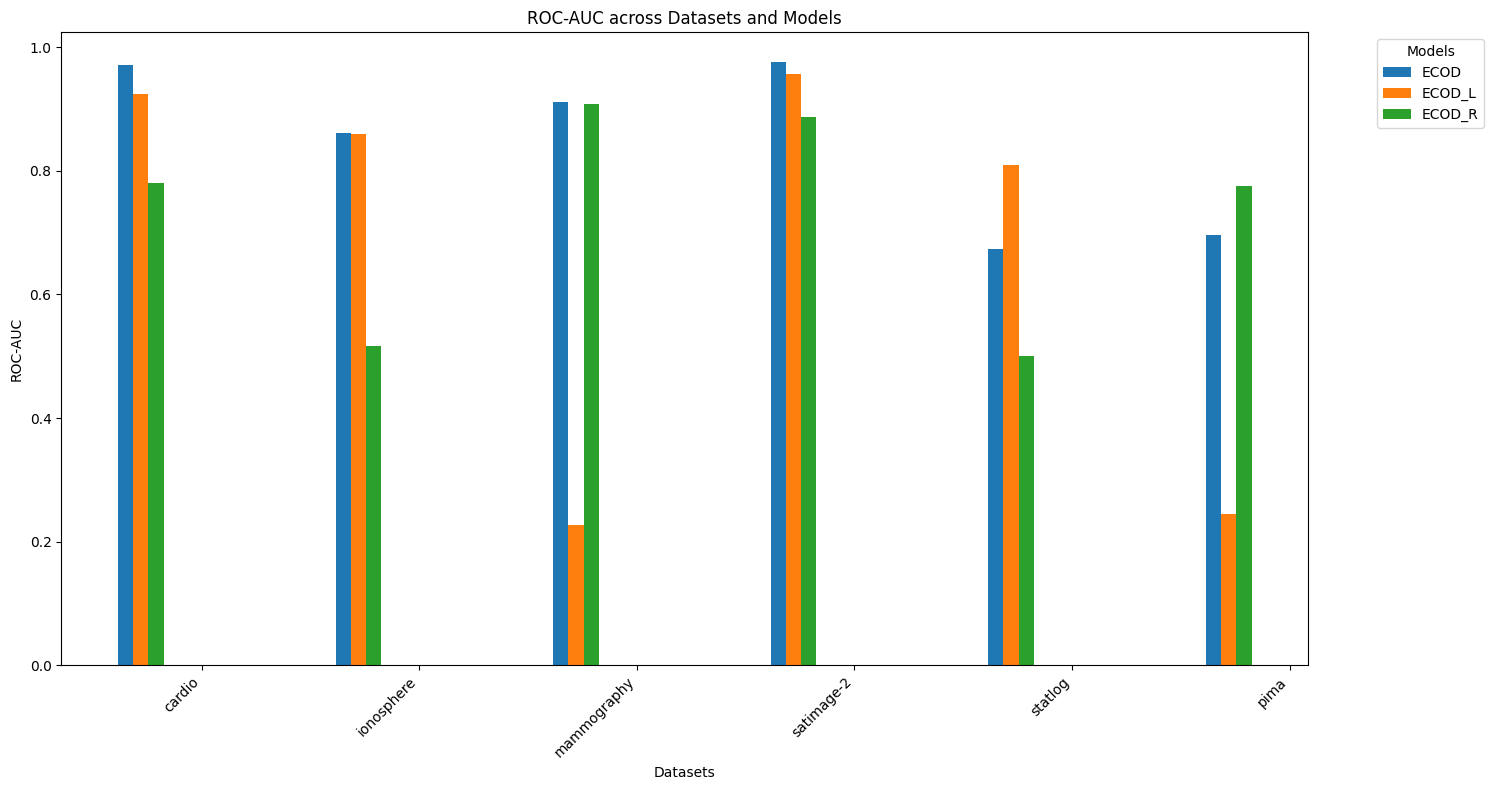

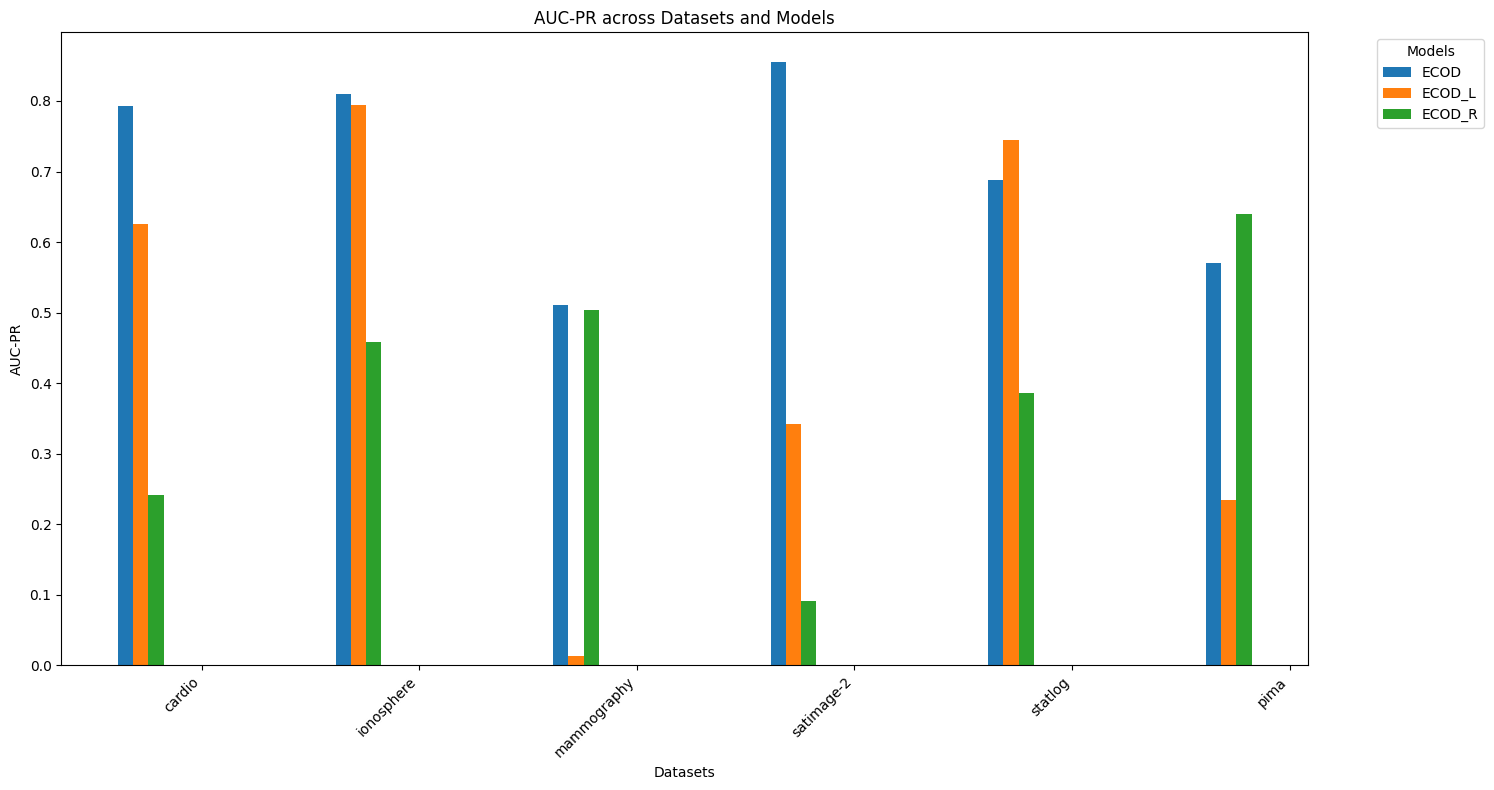

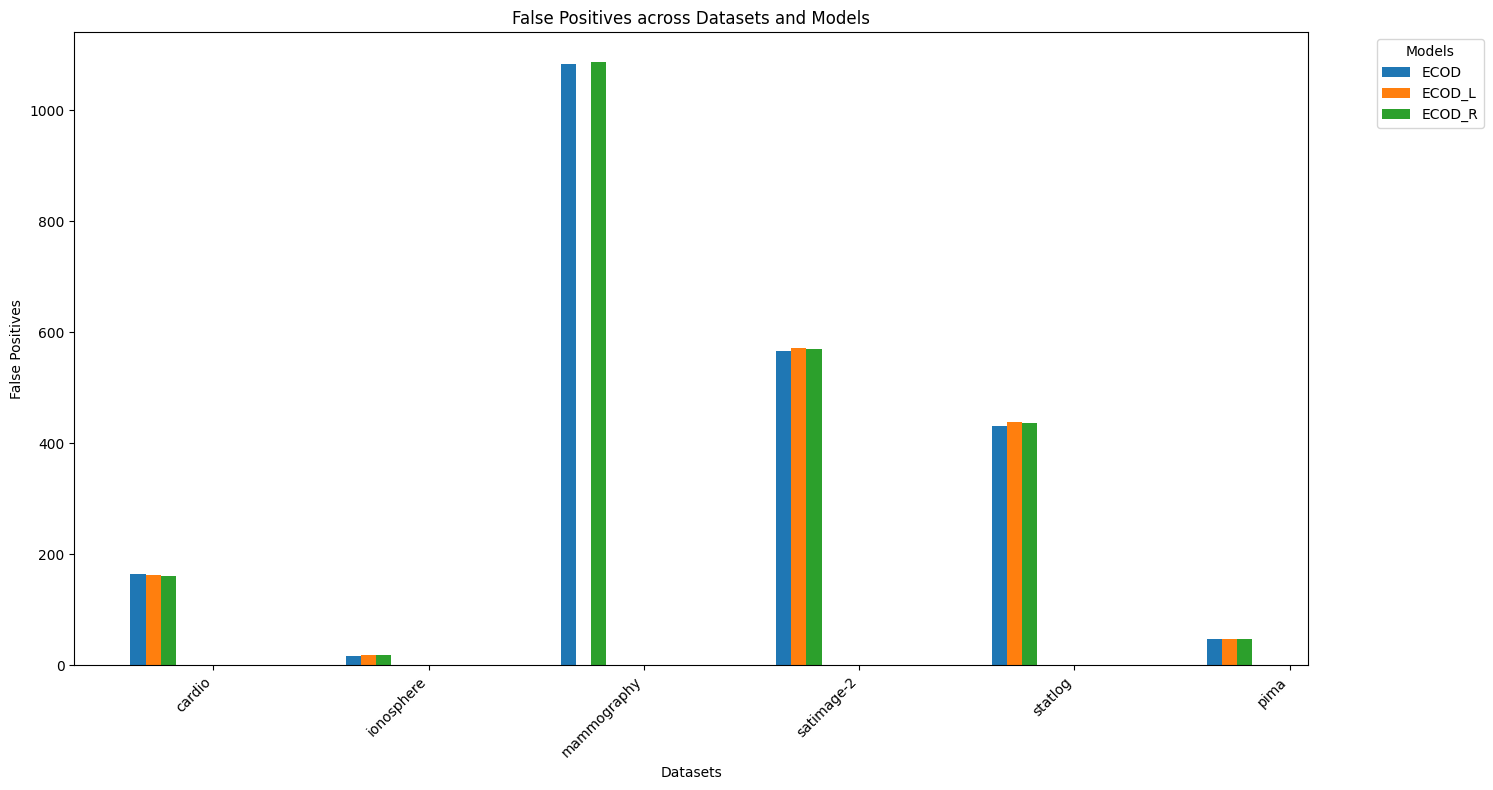

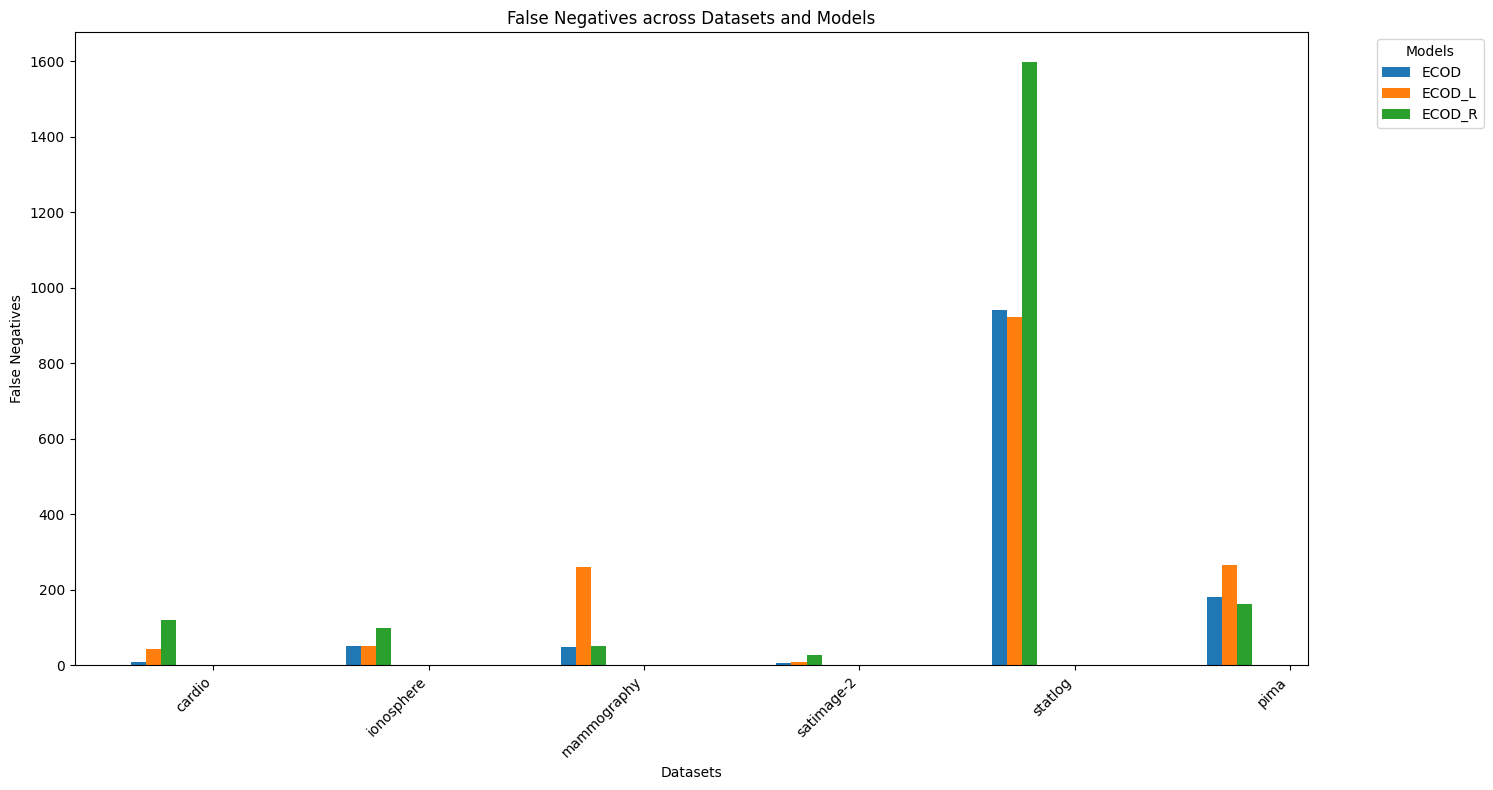

In [54]:

metrics = {
    'ROC-AUC': {
        'ECOD': {'cardio': 0.9713, 'ionosphere': 0.8618, 'mammography': 0.9110,
                'satimage-2': 0.9751, 'statlog': 0.6736, 'pima': 0.6963},
        'ECOD_L': {'cardio': 0.9249, 'ionosphere': 0.8592, 'mammography': 0.2277,
                  'satimage-2': 0.9571, 'statlog': 0.8088, 'pima': 0.2453},
        'ECOD_R': {'cardio': 0.7804, 'ionosphere': 0.5158, 'mammography': 0.9079,
                  'satimage-2': 0.8863, 'statlog': 0.5000, 'pima': 0.7759}
    },
    'AUC-PR': {
        'ECOD': {'cardio': 0.7935, 'ionosphere': 0.8102, 'mammography': 0.5108,
                'satimage-2': 0.8546, 'statlog': 0.6883, 'pima': 0.5697},
        'ECOD_L': {'cardio': 0.6260, 'ionosphere': 0.7946, 'mammography': 0.0139,
                  'satimage-2': 0.3428, 'statlog': 0.7441, 'pima': 0.2343},
        'ECOD_R': {'cardio': 0.2413, 'ionosphere': 0.4578, 'mammography': 0.5042,
                  'satimage-2': 0.0907, 'statlog': 0.3860, 'pima': 0.6402}
    },
    'False Positives': {
        'ECOD': {'cardio': 165, 'ionosphere': 17, 'mammography': 1083,
                'satimage-2': 566, 'statlog': 432, 'pima': 48},
        'ECOD_L': {'cardio': 162, 'ionosphere': 18, 'mammography': 0,
                  'satimage-2': 571, 'statlog': 438, 'pima': 47},
        'ECOD_R': {'cardio': 161, 'ionosphere': 19, 'mammography': 1086,
                  'satimage-2': 569, 'statlog': 436, 'pima': 48}
    },
    'False Negatives': {
        'ECOD': {'cardio': 10, 'ionosphere': 51, 'mammography': 48,
                'satimage-2': 5, 'statlog': 942, 'pima': 181},
        'ECOD_L': {'cardio': 43, 'ionosphere': 52, 'mammography': 260,
                  'satimage-2': 10, 'statlog': 922, 'pima': 266},
        'ECOD_R': {'cardio': 120, 'ionosphere': 98, 'mammography': 52,
                  'satimage-2': 28, 'statlog': 1597, 'pima': 163}
    }
}

# Colors for each model
colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 11))

# Create a plot for each metric
for metric_name, data in metrics.items():
    fig, ax = plt.subplots(figsize=(15, 8))

    datasets = list(data['ECOD'].keys())
    models = list(data.keys())
    x = np.arange(len(datasets))
    width = 0.07  # Width of each bar

    for i, model in enumerate(models):
        values = [data[model][dataset] for dataset in datasets]
        ax.bar(x + i*width, values, width, label=model, color=colors[i])

    ax.set_ylabel(metric_name)
    ax.set_xlabel('Datasets')
    ax.set_title(f'{metric_name} across Datasets and Models')
    ax.set_xticks(x + width * 5)
    ax.set_xticklabels(datasets, rotation=45, ha='right')
    ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [60]:
cardio_path = '/content/drive/MyDrive/AD_data/cardio (1).mat'

ECOD vs ECOD_L vs ECOD_R on cardio.mat

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Reducing dimensions from 21 to 2...
Reduced to 2D using t-SNE
Applying ECOD...
ECOD: 183 anomalies detected.
Applying ECOD_L...
ECOD_L: 183 anomalies detected.
Applying ECOD_R...
ECOD_R: 183 anomalies detected.
Applying ECOD_B...
ECOD_B: 183 anomalies detected.


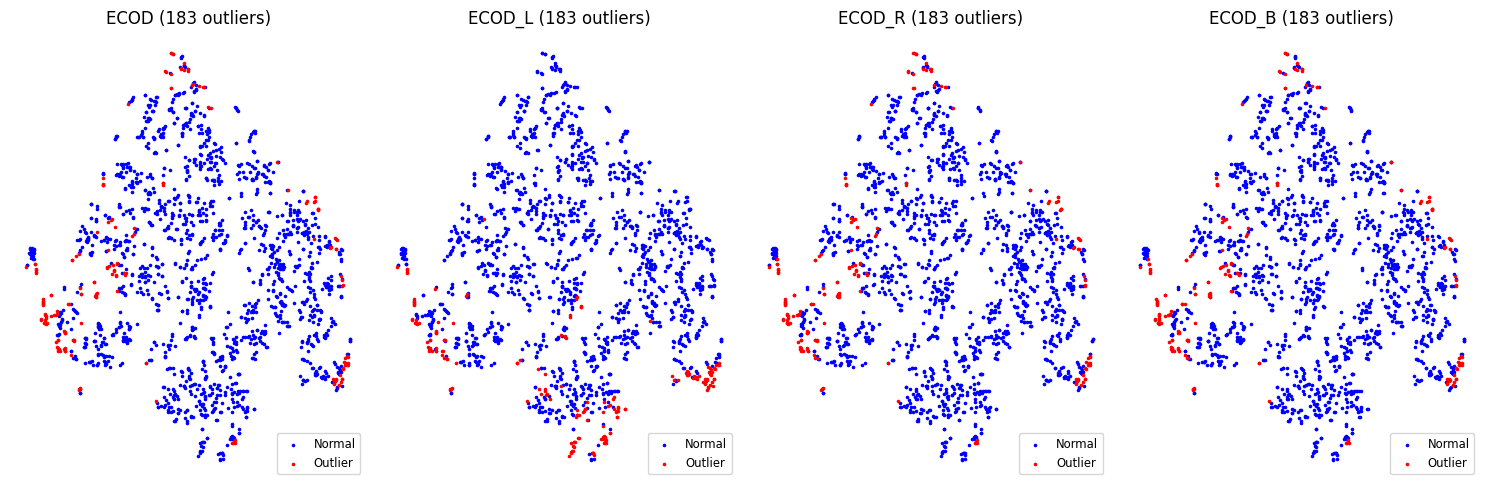

In [63]:
contamination = 0.1
algorithms = {
        "ECOD": ECOD(contamination=contamination),
        "ECOD_L": ECOD_L(contamination=contamination),
        "ECOD_R": ECOD_R(contamination=contamination),
        "ECOD_B": ECOD_B(contamination=contamination)
    }
file_path = cardio_path  # Replace with your actual file path
data = load_data(file_path)
if data is not None:
    # Apply all algorithms with 10% contamination
    plot_multiple_anomaly_detections(algorithms, data)

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Reducing dimensions from 21 to 2...
Reduced to 2D using t-SNE
Normal points: 1655
Anomaly points: 176


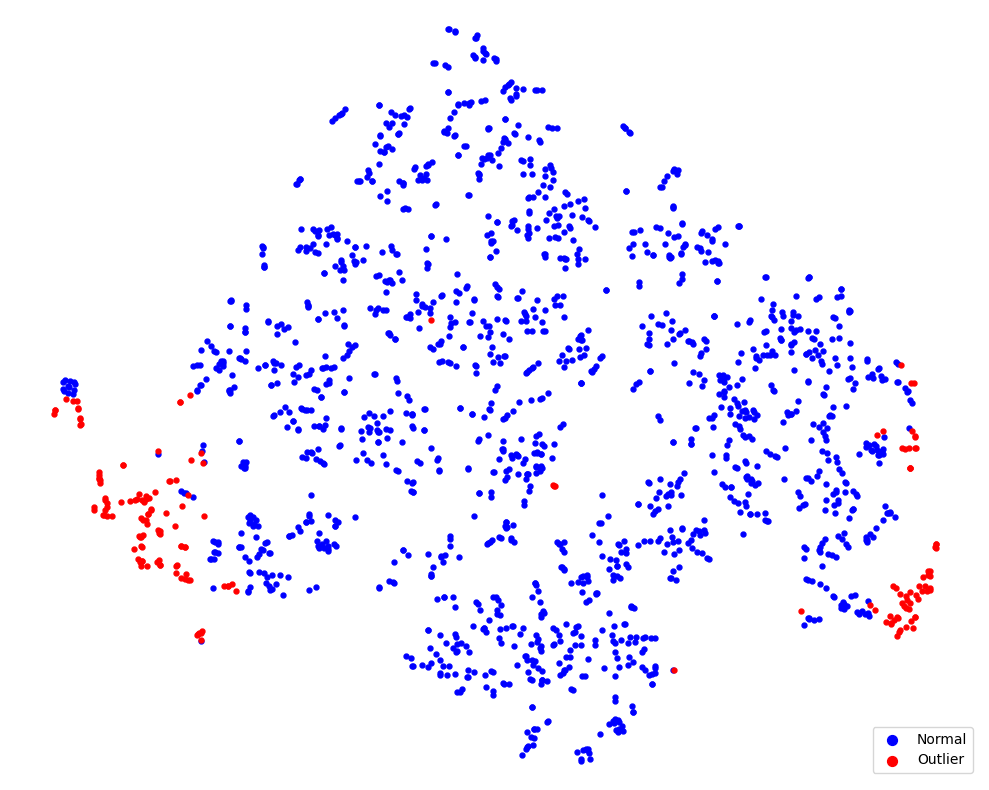

In [65]:
#original cardio with anomalies
file_path = cardio_path  # Replace with the actual file path
data, labels = load_data_with_anomalies(file_path)
if data is not None and labels is not None:
    plot_data_with_anomalies(data, labels)

Possible Imporvements (Introducing Correlation)

In [66]:
def compute_and_plot_correlation_matrix(data):
    # Convert to Pandas DataFrame for easier handling
    df = pd.DataFrame(data)

    # Compute the correlation matrix
    corr_matrix = df.corr()  # This computes Pearson correlation coefficients

    # Print the correlation matrix
    print("Correlation Matrix:")
    print(corr_matrix)

    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title("Feature Correlation Matrix")
    plt.show()
    return corr_matrix

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Correlation Matrix:
          0         1         2         3         4         5         6   \
0   1.000000  0.027340 -0.016729 -0.084135 -0.108647 -0.052730 -0.082762   
1   0.027340  1.000000  0.041596  0.002238 -0.182552 -0.053286 -0.160697   
2  -0.016729  0.041596  1.000000 -0.084679  0.032651 -0.011720  0.263579   
3  -0.084135  0.002238 -0.084679  1.000000  0.258479  0.000595  0.064853   
4  -0.108647 -0.182552  0.032651  0.258479  1.000000  0.115208  0.210252   
5  -0.052730 -0.053286 -0.011720  0.000595  0.115208  1.000000  0.009052   
6  -0.082762 -0.160697  0.263579  0.064853  0.210252  0.009052  1.000000   
7   0.225911 -0.196910 -0.084906 -0.120405 -0.038328  0.050189  0.107228   
8  -0.208307  0.126289  0.108913  0.212798  0.530215  0.030231  0.243634   
9   0.188280 -0.311572 -0.068325 -0.216967 -0.225662 -0.025832 -0.115630   
10 -0.038182 -0.161838  0.001889 -0.085068 -0.262223 -0

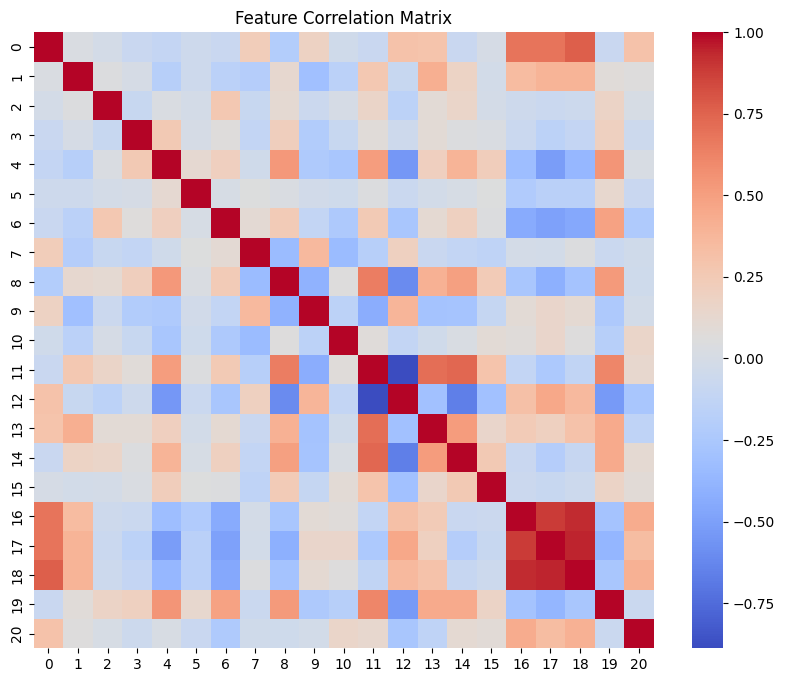

In [67]:
# Main execution
file_path = cardio_path  # Replace with your actual file path
data = load_data(file_path)

corr_matrix = compute_and_plot_correlation_matrix(data)


In [68]:


class ECOD_CUSTOM(BaseDetector):

    def __init__(self, contamination=0.1, n_jobs=1):
        super(ECOD_CUSTOM, self).__init__(contamination=contamination)
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        X = check_array(X)
        self._set_n_classes(y)
        self.decision_scores_ = self.decision_function(X)
        self.X_train = X
        self._process_decision_scores()
        return self

    def compute_correlation_matrix(self, X):
        df = pd.DataFrame(X)
        corr_matrix = df.corr()
        return corr_matrix

    def decision_function(self, X):
        X = check_array(X)

        corr_matrix = self.compute_correlation_matrix(X)
        corr_matrix = np.abs(corr_matrix)
        feature_weights = np.sum(corr_matrix.to_numpy(), axis=1)  # Convert DataFrame to NumPy array
        feature_weights /= np.max(feature_weights)
        feature_weights = 1 - feature_weights
        X = X * feature_weights[np.newaxis, :]

        if hasattr(self, 'X_train'):
            original_size = X.shape[0]
            X = np.concatenate((self.X_train, X), axis=0)

        # Calculate right-tail probabilities
        self.U_r = -1 * np.log(column_ecdf(-X))

        # Use only right-tail (ECOD-R variant)
        self.O = self.U_r

        if hasattr(self, 'X_train'):
            decision_scores_ = self.O.sum(axis=1)[-original_size:]
        else:
            decision_scores_ = self.O.sum(axis=1)

        return decision_scores_.ravel()


In [74]:
algorithms = {
    'ECOD_CUSTOM': ECOD_CUSTOM(),
    'ECOD': ECOD()
}

# Define datasets
datasets = {
    'cardio': '/content/drive/MyDrive/AD_data/cardio (1).mat',
    'ionosphere': '/content/drive/MyDrive/AD_data/ionosphere (1).mat',
    'mammography': '/content/drive/MyDrive/AD_data/mammography (1).mat',
    'satimage-2': '/content/drive/MyDrive/AD_data/satimage-2 (1).mat',
    'statlog': '/content/drive/MyDrive/AD_data/statlog (1).mat',
    'pima': '/content/drive/MyDrive/AD_data/pima (1).mat'

}

# Define device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run evaluation
results = evaluate_models(algorithms, datasets, device)

# Print or process results as needed
print("Evaluation results:")
print(results)

Evaluating on dataset: cardio
Running ECOD_CUSTOM...
ECOD_CUSTOM:
ROC-AUC: 0.5000 | AUC-PR: 0.0961
False Positives: 0 | False Negatives: 176

Running ECOD...
ECOD:
ROC-AUC: 0.9713 | AUC-PR: 0.7935
False Positives: 165 | False Negatives: 10

Evaluating on dataset: ionosphere
Running ECOD_CUSTOM...
ECOD_CUSTOM:
ROC-AUC: 0.5000 | AUC-PR: 0.3590
False Positives: 0 | False Negatives: 126

Running ECOD...
ECOD:
ROC-AUC: 0.8618 | AUC-PR: 0.8102
False Positives: 17 | False Negatives: 51

Evaluating on dataset: mammography
Running ECOD_CUSTOM...
ECOD_CUSTOM:
ROC-AUC: 0.5000 | AUC-PR: 0.0232
False Positives: 0 | False Negatives: 260

Running ECOD...
ECOD:
ROC-AUC: 0.9110 | AUC-PR: 0.5108
False Positives: 1083 | False Negatives: 48

Evaluating on dataset: satimage-2
Running ECOD_CUSTOM...
ECOD_CUSTOM:
ROC-AUC: 0.5000 | AUC-PR: 0.0122
False Positives: 0 | False Negatives: 71

Running ECOD...
ECOD:
ROC-AUC: 0.9751 | AUC-PR: 0.8546
False Positives: 566 | False Negatives: 5

Evaluating on dataset: st

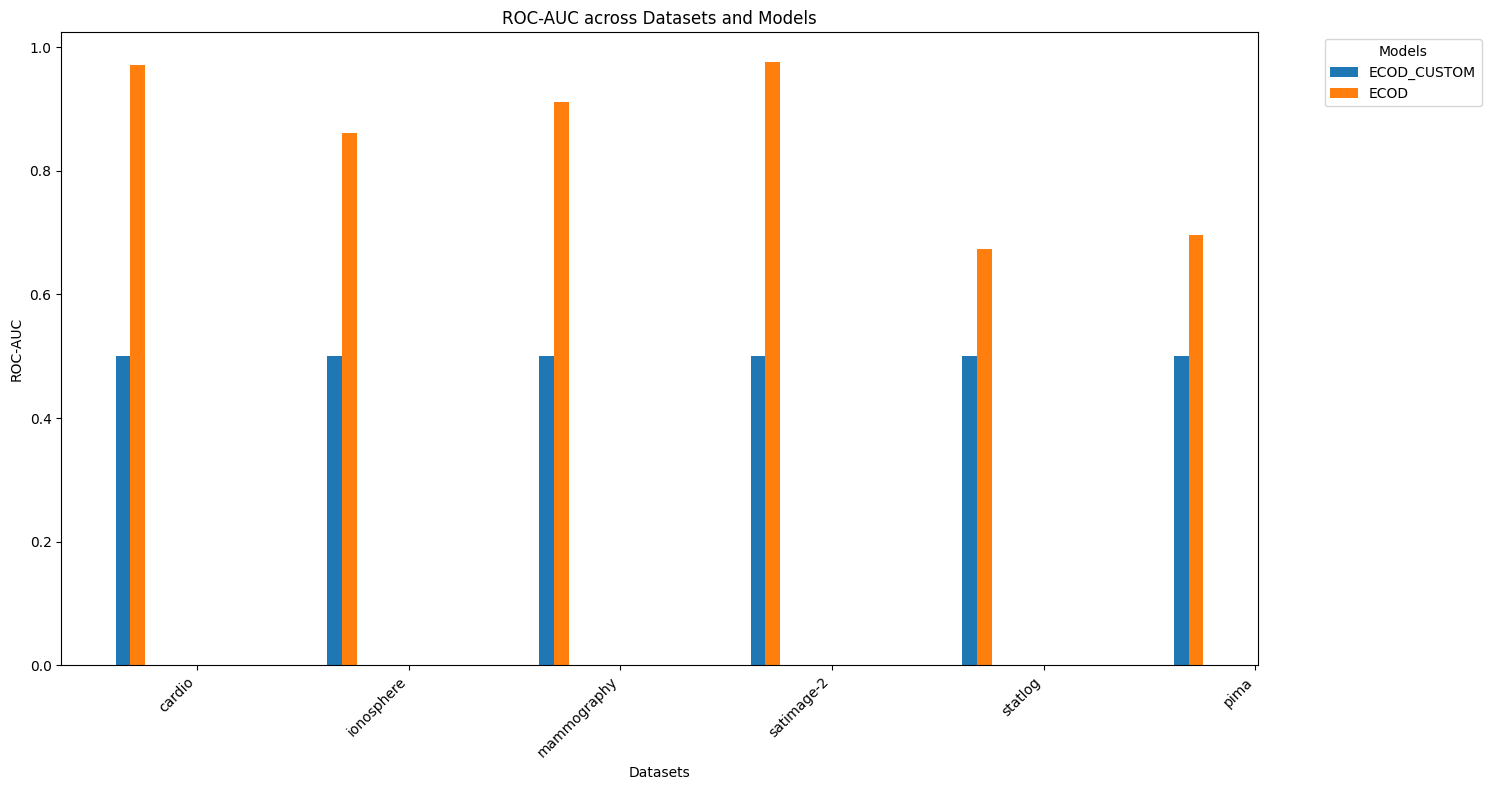

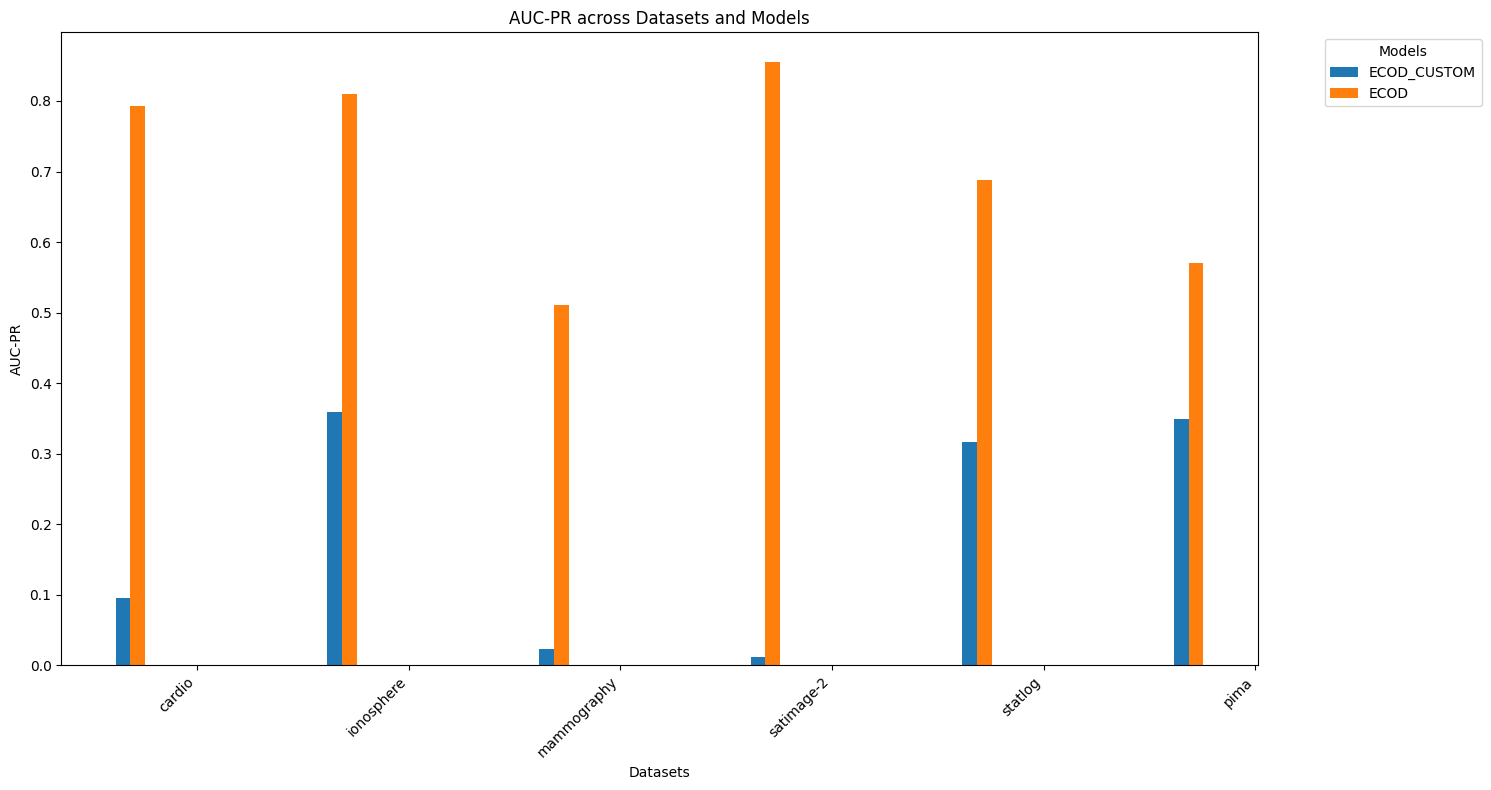

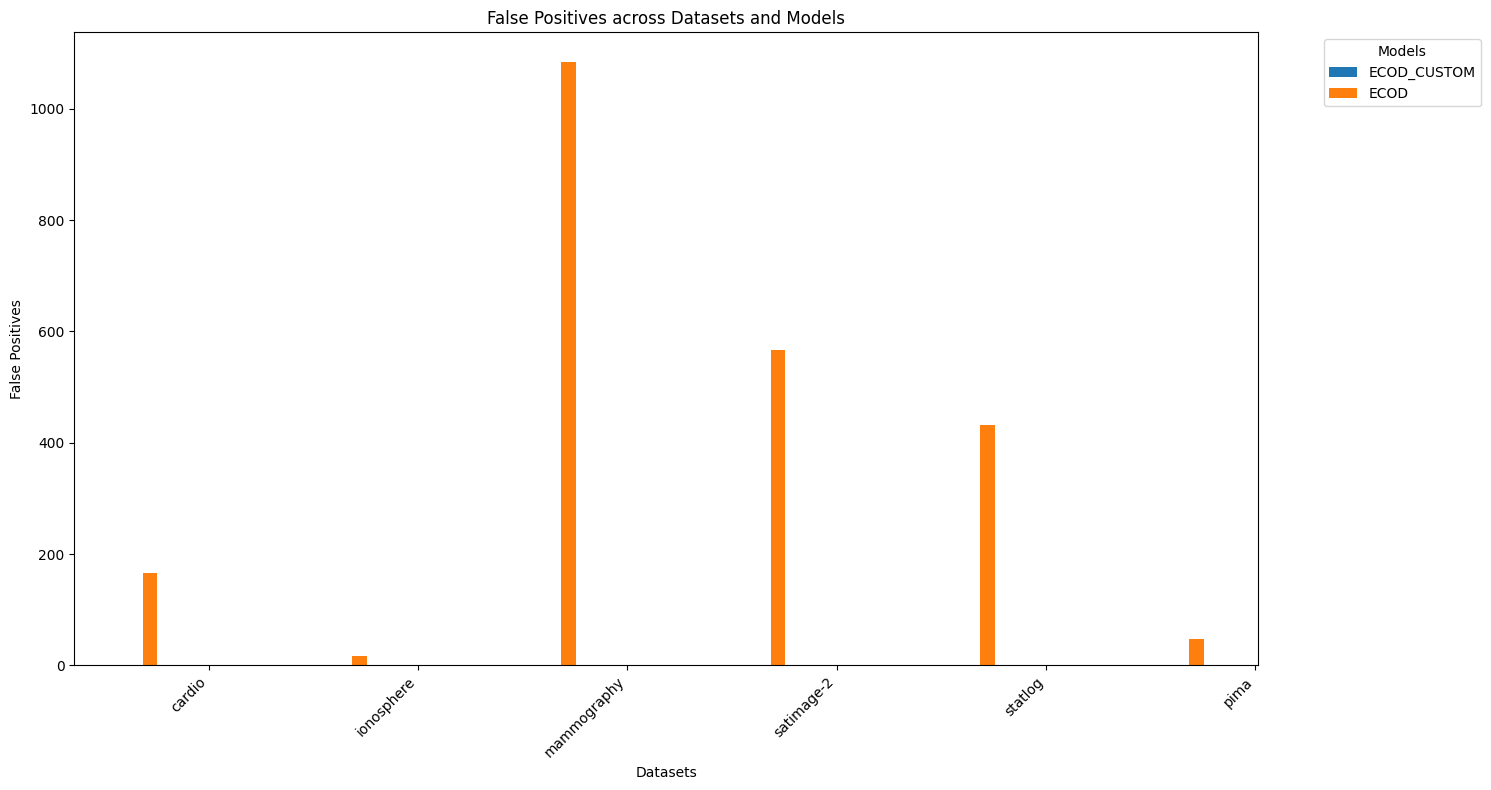

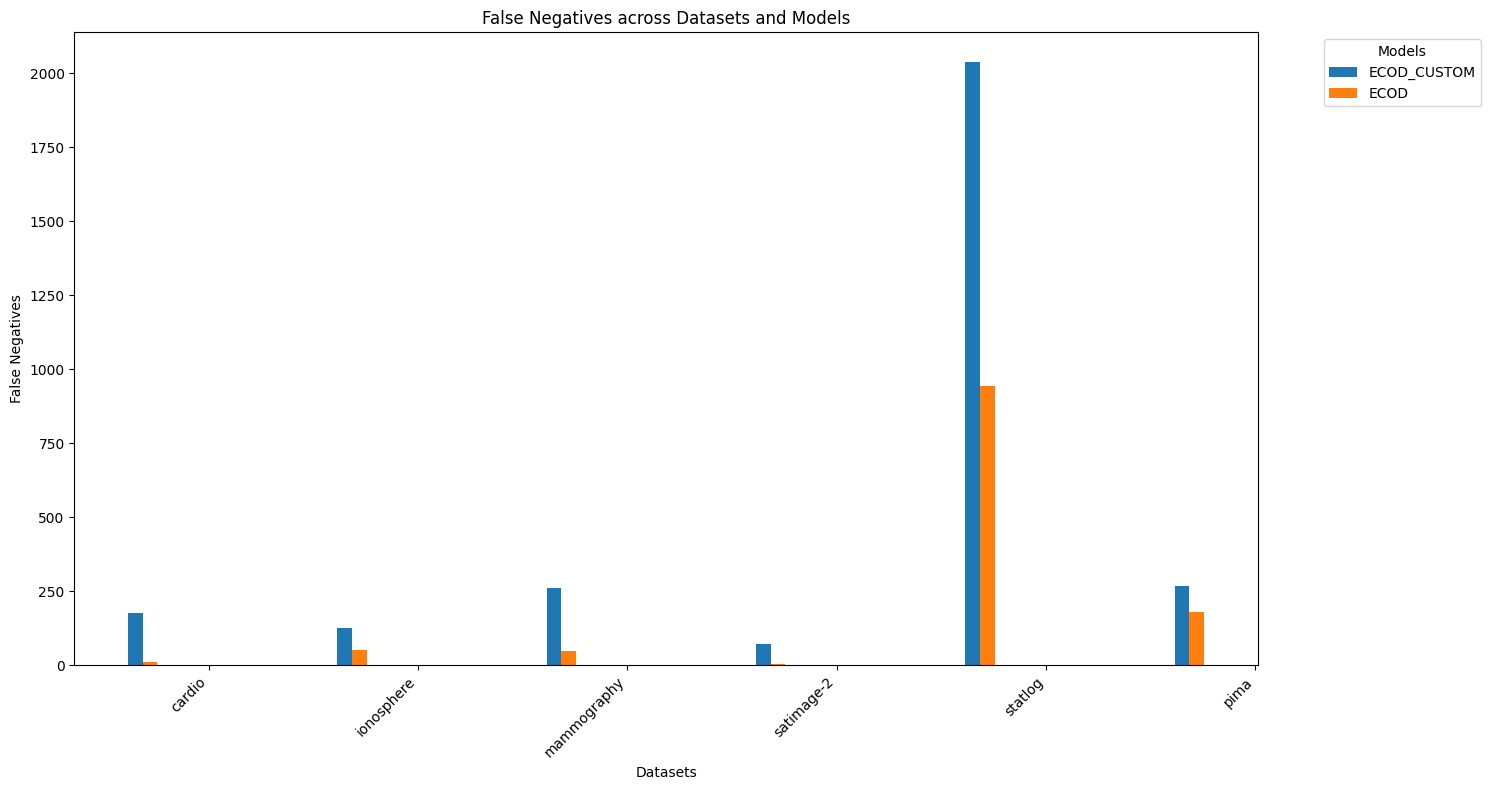

In [76]:
metrics = {
    'ROC-AUC': {
        'ECOD_CUSTOM': {'cardio': 0.5000, 'ionosphere': 0.5000, 'mammography': 0.5000,
                        'satimage-2': 0.5000, 'statlog': 0.5000, 'pima': 0.5000},
        'ECOD': {'cardio': 0.9713, 'ionosphere': 0.8618, 'mammography': 0.9110,
                 'satimage-2': 0.9751, 'statlog': 0.6736, 'pima': 0.6963}
    },
    'AUC-PR': {
        'ECOD_CUSTOM': {'cardio': 0.0961, 'ionosphere': 0.3590, 'mammography': 0.0232,
                        'satimage-2': 0.0122, 'statlog': 0.3164, 'pima': 0.3490},
        'ECOD': {'cardio': 0.7935, 'ionosphere': 0.8102, 'mammography': 0.5108,
                 'satimage-2': 0.8546, 'statlog': 0.6883, 'pima': 0.5697}
    },
    'False Positives': {
        'ECOD_CUSTOM': {'cardio': 0, 'ionosphere': 0, 'mammography': 0,
                        'satimage-2': 0, 'statlog': 0, 'pima': 0},
        'ECOD': {'cardio': 165, 'ionosphere': 17, 'mammography': 1083,
                 'satimage-2': 566, 'statlog': 432, 'pima': 48}
    },
    'False Negatives': {
        'ECOD_CUSTOM': {'cardio': 176, 'ionosphere': 126, 'mammography': 260,
                        'satimage-2': 71, 'statlog': 2036, 'pima': 268},
        'ECOD': {'cardio': 10, 'ionosphere': 51, 'mammography': 48,
                 'satimage-2': 5, 'statlog': 942, 'pima': 181}
    }
}

# Colors for each model
colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 11))

# Create a plot for each metric
for metric_name, data in metrics.items():
    fig, ax = plt.subplots(figsize=(15, 8))

    datasets = list(data['ECOD'].keys())
    models = list(data.keys())
    x = np.arange(len(datasets))
    width = 0.07  # Width of each bar

    for i, model in enumerate(models):
        values = [data[model][dataset] for dataset in datasets]
        ax.bar(x + i*width, values, width, label=model, color=colors[i])

    ax.set_ylabel(metric_name)
    ax.set_xlabel('Datasets')
    ax.set_title(f'{metric_name} across Datasets and Models')
    ax.set_xticks(x + width * 5)
    ax.set_xticklabels(datasets, rotation=45, ha='right')
    ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


Visulizing ECOD vs ECOD_CUSTOM on cardio.mat

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Reducing dimensions from 21 to 2...
Reduced to 2D using t-SNE
Applying ECOD...
ECOD: 183 anomalies detected.
Applying ECOD_CUSTOM...
ECOD_CUSTOM: 25 anomalies detected.


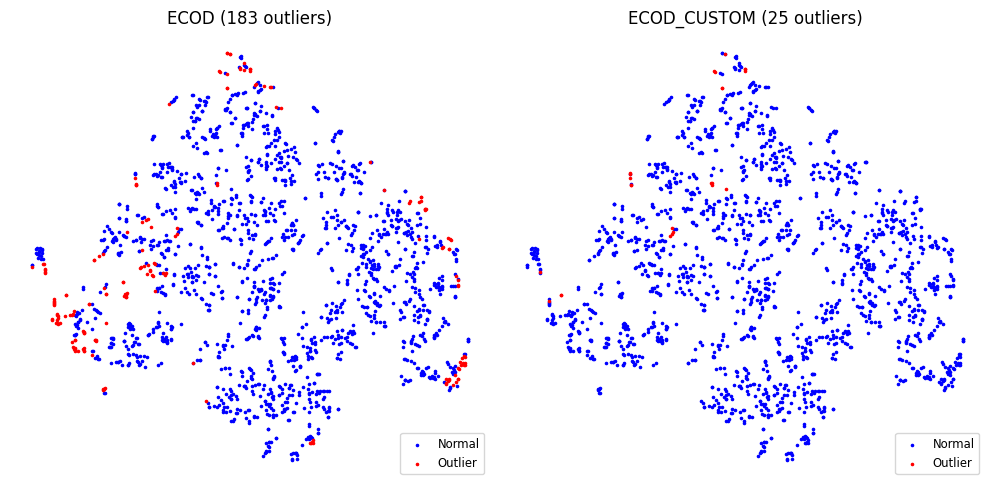

In [72]:
contamination = 0.1
algorithms = {
        "ECOD": ECOD(contamination=contamination),
        "ECOD_CUSTOM": ECOD_CUSTOM(contamination=contamination)
    }
file_path = cardio_path  # Replace with your actual file path
data = load_data(file_path)
if data is not None:
    # Apply all algorithms with 10% contamination
    plot_multiple_anomaly_detections(algorithms, data)

Visualizing ECOD vs ECOD_CUSTOM on mammography.mat

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Reducing dimensions from 6 to 2...
Reduced to 2D using t-SNE
Applying ECOD...
ECOD: 1119 anomalies detected.
Applying ECOD_CUSTOM...
ECOD_CUSTOM: 222 anomalies detected.


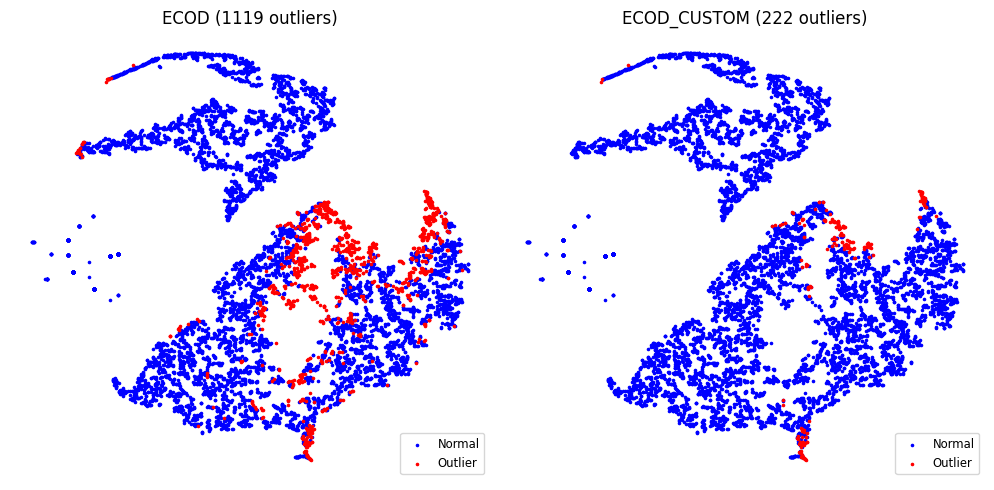

In [73]:
contamination = 0.1
algorithms = {
        "ECOD": ECOD(contamination=contamination),
        "ECOD_CUSTOM": ECOD_CUSTOM(contamination=contamination)
    }
file_path = path  # Replace with your actual file path
data = load_data(file_path)
if data is not None:
    # Apply all algorithms with 10% contamination
    plot_multiple_anomaly_detections(algorithms, data)